# Test RNN sur le petit déjeuner
avec prise en compte de l'identité utilisateur pour les repas
test de l'intégration du user embedding (état caché initial ou à chaque étape) vs controle sans intégration du user embedding


Source utilisée pour la programmation dans ce notebook :
"Module 4 : RNN et attention pour le texte", Auteur: Vincent Guigue
https://github.com/vguigue/tuto_deep/blob/main/notebooks/4_1-rnn-gen.ipynb

In [2]:
# !pip install torchtext
from packaging import version
from pathlib import Path
from itertools import chain
from typing import Iterable, List, Tuple

import shutil
import torchtext
assert version.Version(torchtext.__version__) >= version.Version("0.9.0")
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab, FastText
from collections import Counter
from tqdm.autonotebook import tqdm
from torch.nn.utils.rnn import pad_sequence
import sentencepiece as spm
from IPython.display import display, HTML
import os


cachepath = os.path.expanduser('~/.local/data')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# outils avancés de gestion des chemins
BASEPATH = Path("xp/generation")
TB_PATH =  BASEPATH / "logs"
TB_PATH.mkdir(parents=True, exist_ok=True)

# usage externe de tensorboard: (1) lancer la commande dans une console; (2) copier-coller l'URL dans un navigateur
display(HTML("<h2>Informations</h2><div>Pour visualiser les logs, tapez la commande : </div>"))
print(f"tensorboard --logdir {Path(TB_PATH).absolute()}")

C:\Users\jacqueno\AppData\Local\Temp\ipykernel_56900\2790905849.py:20: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


tensorboard --logdir C:\Users\jacqueno\Documents\IODAA\EXERSYS\final_to_git\Modele_RNN\Petit_Dej\xp\generation\logs


In [3]:
# !pip install sentencepiece
# !pip install datasets
# # !pip install fsspec==2021.8.1
# !pip uninstall huggingface-hub


#  A. Chargement des données

In [4]:
#ADAPTATION EXERSYS 
import pickle
with open("./d_new_pdj.pkl", "rb") as fichier:
    d_new_pdj = pickle.load(fichier)

In [5]:
print(d_new_pdj)

{110006: {}, 110007: {}, 110020: {}, 110021: {}, 110025: {1: [18004, 19041, 31016, 7601, 18066], 2: [18004, 19041, 31016, 7601, 18066], 3: [18004, 19041, 31016, 7001, 16632, 18066]}, 110034: {}, 110046: {}, 110057: {}, 110067: {2: [18004, 7601, 2012, 31016], 3: [18004, 7601, 31016, 2012], 4: [18004, 31016, 7601, 2012], 5: [18004, 31016, 7601, 2012], 6: [18004, 31016, 7601, 2012]}, 110071: {1: [18004, 18066, 81052], 2: [18004, 7001, 31008, 16400, 81052], 3: [18004, 7001, 18066, 16400, 31008, 81052], 4: [18004, 81052], 5: [18004, 81052], 6: [18004, 18066, 81052], 7: [18004, 81052]}, 110081: {}, 110110: {2: [18020, 19041], 3: [18020, 19041, 7001, 16402, 31008], 4: [18020, 19041], 5: [18020, 19041], 6: [18020, 19041], 7: [18020, 19041, 13039]}, 110113: {1: [19041, 7001, 31006, 18150], 2: [19050, 18150, 7001, 31006], 3: [19050, 18150, 7001, 31006], 4: [19050, 18150], 5: [19050, 7741], 6: [19050, 7741], 7: [19041, 7001, 31006]}, 110125: {5: [13005, 13039, 18066], 7: [7100, 16402, 18020, 3101

In [6]:
import copy
import numpy as np

dic_userseqpdj_start={}
# print(dic_userseqrepas)
for cle, valeur in d_new_pdj.items():
    if len(valeur)>0:
        dic_userseqpdj_start[cle]=valeur
# print(dic_userseqpdj_start)

dic_userseqpdj={}
for cle, valeur in dic_userseqpdj_start.items():
    for sscle, ssval in valeur.items():
        dic_userseqpdj.setdefault(cle, []).append(ssval)
        
# print(dic_userseqpdj)

# Créez un nouveau dictionnaire pour stocker les valeurs converties en str
new_dic_userseqpdj = {}

for cle, valeur in dic_userseqpdj.items():
    # Parcourez chaque sous-liste et convertissez les nombres en str
    nouvelle_valeur = [[str(nombre) for nombre in sous_liste] for sous_liste in valeur]
    # Stockez la nouvelle valeur dans le nouveau dictionnaire
    new_dic_userseqpdj[cle] = nouvelle_valeur

# Maintenant, nouveau_dictionnaire contient les valeurs avec des nombres convertis en str
print(new_dic_userseqpdj)

{110025: [['18004', '19041', '31016', '7601', '18066'], ['18004', '19041', '31016', '7601', '18066'], ['18004', '19041', '31016', '7001', '16632', '18066']], 110067: [['18004', '7601', '2012', '31016'], ['18004', '7601', '31016', '2012'], ['18004', '31016', '7601', '2012'], ['18004', '31016', '7601', '2012'], ['18004', '31016', '7601', '2012']], 110071: [['18004', '18066', '81052'], ['18004', '7001', '31008', '16400', '81052'], ['18004', '7001', '18066', '16400', '31008', '81052'], ['18004', '81052'], ['18004', '81052'], ['18004', '18066', '81052'], ['18004', '81052']], 110110: [['18020', '19041'], ['18020', '19041', '7001', '16402', '31008'], ['18020', '19041'], ['18020', '19041'], ['18020', '19041'], ['18020', '19041', '13039']], 110113: [['19041', '7001', '31006', '18150'], ['19050', '18150', '7001', '31006'], ['19050', '18150', '7001', '31006'], ['19050', '18150'], ['19050', '7741'], ['19050', '7741'], ['19041', '7001', '31006']], 110125: [['13005', '13039', '18066'], ['7100', '164

In [7]:
import numpy as np

alim_pdj=[]
for cle, liste_de_listes in new_dic_userseqpdj.items():
    for sous_liste in liste_de_listes:
        alim_pdj.extend(sous_liste)
features=np.unique(alim_pdj).tolist()   

print(len(features))
print(features)

55
['13005', '13021', '13024', '13034', '13039', '16400', '16402', '16412', '16632', '16727', '16730', '18004', '18005', '18008', '18020', '18066', '18071', '18073', '18101', '18150', '18151', '19041', '19050', '19600', '2004', '2012', '2013', '2070', '24231', '24630', '31006', '31008', '31016', '31017', '31019', '31024', '31032', '31037', '31110', '7001', '7004', '7012', '7100', '7110', '7200', '7255', '7300', '7601', '7620', '7710', '7730', '7740', '7741', '81052', '92030']


In [8]:
liste_alim_pdj=[]
for cle, liste_de_listes in new_dic_userseqpdj.items():
    for sous_liste in liste_de_listes:
        liste_alim_pdj.append(sous_liste)
print(liste_alim_pdj)    

[['18004', '19041', '31016', '7601', '18066'], ['18004', '19041', '31016', '7601', '18066'], ['18004', '19041', '31016', '7001', '16632', '18066'], ['18004', '7601', '2012', '31016'], ['18004', '7601', '31016', '2012'], ['18004', '31016', '7601', '2012'], ['18004', '31016', '7601', '2012'], ['18004', '31016', '7601', '2012'], ['18004', '18066', '81052'], ['18004', '7001', '31008', '16400', '81052'], ['18004', '7001', '18066', '16400', '31008', '81052'], ['18004', '81052'], ['18004', '81052'], ['18004', '18066', '81052'], ['18004', '81052'], ['18020', '19041'], ['18020', '19041', '7001', '16402', '31008'], ['18020', '19041'], ['18020', '19041'], ['18020', '19041'], ['18020', '19041', '13039'], ['19041', '7001', '31006', '18150'], ['19050', '18150', '7001', '31006'], ['19050', '18150', '7001', '31006'], ['19050', '18150'], ['19050', '7741'], ['19050', '7741'], ['19041', '7001', '31006'], ['13005', '13039', '18066'], ['7100', '16402', '18020', '31016'], ['7001', '31037', '2013', '18004', 

In [9]:
# Convertir les sous-listes en phrases (chaînes de caractères)
liste_alim_pdj_sentences = [' '.join(sublist) for sublist in liste_alim_pdj]
print(liste_alim_pdj_sentences)

['18004 19041 31016 7601 18066', '18004 19041 31016 7601 18066', '18004 19041 31016 7001 16632 18066', '18004 7601 2012 31016', '18004 7601 31016 2012', '18004 31016 7601 2012', '18004 31016 7601 2012', '18004 31016 7601 2012', '18004 18066 81052', '18004 7001 31008 16400 81052', '18004 7001 18066 16400 31008 81052', '18004 81052', '18004 81052', '18004 18066 81052', '18004 81052', '18020 19041', '18020 19041 7001 16402 31008', '18020 19041', '18020 19041', '18020 19041', '18020 19041 13039', '19041 7001 31006 18150', '19050 18150 7001 31006', '19050 18150 7001 31006', '19050 18150', '19050 7741', '19050 7741', '19041 7001 31006', '13005 13039 18066', '7100 16402 18020 31016', '7001 31037 2013 18004 18066', '18004 81052', '18004 81052', '18004 81052', '18004 7620 31006', '18004 19041 7620 31006', '18004 19041 7620 31006', '18004 19041 7100 31006', '18004 19041 31006', '18151 81052', '18151 31017 7741 31037 2012', '18004 19041 31017 7741 31037 2012', '18004 19041 31017 7741 31037 2012',

In [10]:
import copy
import numpy as np

# print(dic_userseqpdj)
dic_userseqpdj_min3=copy.deepcopy(dic_userseqpdj)
for cle, valeur in dic_userseqpdj.items():
        if len(valeur)<3:
#             print(cle, len(valeur))
            del dic_userseqpdj_min3[cle]

print(len(dic_userseqpdj))
print(len(dic_userseqpdj_min3))

dic_user_pdj_train={}
dic_user_pdj_valid={}
dic_user_pdj_test={}
for cle, valeur in dic_userseqpdj_min3.items():
    r=0
    for pdj in valeur:
        r+=1
        if r<len(valeur)-1:
            dic_user_pdj_train.setdefault(cle, []).append(pdj)
        elif r==len(valeur)-1:
            dic_user_pdj_valid.setdefault(cle, []).append(pdj)
        elif r==len(valeur):
            dic_user_pdj_test.setdefault(cle, []).append(pdj)
# dic_user_pdj_train

train_data_old=[]
train_user_ids=[]
valid_data_old=[]
valid_user_ids=[]
test_data_old=[]
test_user_ids=[]

for cle, valeur in dic_user_pdj_train.items():
    for pdj in valeur:
        train_data_old.append(pdj)
        train_user_ids.append(cle) 
# print(len(train_data_old))
# print(len(train_user_ids))

for cle, valeur in dic_user_pdj_valid.items():
    for pdj in valeur:
        valid_data_old.append(pdj)
        valid_user_ids.append(cle)        
# print((valid_data_old))
# print((valid_user_ids))

for cle, valeur in dic_user_pdj_test.items():
    for pdj in valeur:
        test_data_old.append(pdj)
        test_user_ids.append(cle)    

print(len(np.unique(train_user_ids)))
print(len(np.unique(valid_user_ids)))
print(len(np.unique(test_user_ids)))


1738
1274
1274
1274
1274


In [11]:
# charger dictionnaire des noms d'aliments
with open("./dic_alim.pkl", "rb") as fichier:
    dic_alim = pickle.load(fichier)

In [12]:
#Regarder la composition de quelques petits déjeuners 
for p in liste_alim_pdj[:50]:
    print("\n =>nouveau petit déjeuner:")
    for e in p:
        print(dic_alim[int(e.replace("'",""))])


 =>nouveau petit déjeuner:
café noir prêt à boire non sucré
lait demi-écrémé uht
sucre blanc
croissant sans précision
eau du robinet

 =>nouveau petit déjeuner:
café noir prêt à boire non sucré
lait demi-écrémé uht
sucre blanc
croissant sans précision
eau du robinet

 =>nouveau petit déjeuner:
café noir prêt à boire non sucré
lait demi-écrémé uht
sucre blanc
pain baguette
matière grasse allégée 60% m.g.
eau du robinet

 =>nouveau petit déjeuner:
café noir prêt à boire non sucré
croissant sans précision
jus d'orange à base de concentré pasteurisé
sucre blanc

 =>nouveau petit déjeuner:
café noir prêt à boire non sucré
croissant sans précision
sucre blanc
jus d'orange à base de concentré pasteurisé

 =>nouveau petit déjeuner:
café noir prêt à boire non sucré
sucre blanc
croissant sans précision
jus d'orange à base de concentré pasteurisé

 =>nouveau petit déjeuner:
café noir prêt à boire non sucré
sucre blanc
croissant sans précision
jus d'orange à base de concentré pasteurisé

 =>nouve

# B. Preprocessing

In [13]:
#ADAPTATION EXERSYS 
class Preprocessor:
    def process_batch(self, batch: List[str]):            
        return pad_sequence([self.string2idx(text) for text in batch])

class SentencePiecePreprocessor(Preprocessor):
    """Tokenizer Sentence Piece"""
    def embeddings(self, dimension: int):
        return nn.Embedding(self.vocab_size, dimension, padding_idx=self.pad_index)
    
    @property
    def vocab_size(self):
        return self.spm_tokenizer.vocab_size()

    def __init__(self, name: str, sentences: Iterable[str], vocab_size=len(features)+4, force=False):
        modelpath = BASEPATH / f"{name}-{vocab_size}.model"
        if not modelpath.exists() or force:
            print(f"Entraînement de SPM, sortie {BASEPATH}/{name}-{vocab_size}", flush=True)
            spm.SentencePieceTrainer.train(
                sentence_iterator=iter(sentences), 
                model_prefix=f"{BASEPATH}/{name}-{vocab_size}", 
                vocab_size=vocab_size,
                model_type="word",
                pad_id=0,                
                unk_id=1,
                bos_id=2,
                eos_id=3
            )
            
        self.spm_tokenizer = spm.SentencePieceProcessor()
        self.spm_tokenizer.load(str(modelpath))

        self.pad_index = self.spm_tokenizer.pad_id()
        self.eos_index = self.spm_tokenizer.eos_id()
        self.bos_index = self.spm_tokenizer.bos_id()
        self.oov_index = None

        self.spm_tokenizer.SetEncodeExtraOptions("bos:eos")

    def string2idx(self, s: str) -> torch.Tensor:
        return torch.tensor(self.spm_tokenizer.EncodeAsIds(s))

    def tokenizer(self, x):
        """Segmentation du texte en sous-mots"""
        return self.spm_tokenizer.encode_as_pieces(x)

    def id2token(self, ix):
        return self.spm_tokenizer.IdToPiece(ix)

    def decode(self, ids: List[int]):
        return self.spm_tokenizer.Decode(ids)



preprocessor = SentencePiecePreprocessor("spm", liste_alim_pdj_sentences, force=False)
print(f"Vocabulary size: {preprocessor.vocab_size}")

Entraînement de SPM, sortie xp\generation/spm-59
Vocabulary size: 59


In [14]:
#ADAPTATION EXERSYS 
# exemple de décomposition 
preprocessor.tokenizer(['18004 19041 31016 7601 18066'])

[['<s>', '▁18004', '▁19041', '▁31016', '▁7601', '▁18066', '</s>']]

In [15]:
#ADAPTATION EXERSYS 
out = preprocessor.process_batch(['18004 19041 31016 7601 18066']) # => tenseur d'indices présenté en colonne
print(out)
print(out.shape)

tensor([[ 2],
        [ 4],
        [ 6],
        [ 5],
        [38],
        [10],
        [ 3]])
torch.Size([7, 1])


In [16]:
#ADAPTATION EXERSYS 
# transformation inverse (index => token)
# attention (toujours aux dimensions) : si on oublie le squeeze => list de token

print(preprocessor.decode(out.tolist()))
print(preprocessor.decode(out.squeeze().tolist()))

['', '18004', '19041', '31016', '7601', '18066', '']
18004 19041 31016 7601 18066


In [17]:
#ADAPTATION EXERSYS 
# reflexion sur le padding
x_exemple = preprocessor.process_batch(['18004 19041 31016 7601 18066', '18004 19041 31016 7601, 18066'])
print("Dimension de x :", x_exemple.size()) # T x batch_size x dim_input
print(x_exemple)

Dimension de x : torch.Size([7, 2])
tensor([[ 2,  2],
        [ 4,  4],
        [ 6,  6],
        [ 5,  5],
        [38,  1],
        [10, 10],
        [ 3,  3]])


In [87]:
#ADAPTATION EXERSYS 
# récupération automatique d'une lookup table (tableau d'embeddings):
embeddings = preprocessor.embeddings(50) # taille vaocabulaire x dim = 50

print("taille de la table:", embeddings.num_embeddings, "x", embeddings.embedding_dim)

taille de la table: 59 x 50


In [93]:
#ADAPTATION EXERSYS 
# verification sur la nature de la représentation du mot de padding

x = embeddings(preprocessor.process_batch(['18004 19041 31016 7601 18066', '18004 19041 31016 7601 18066']))
print("Dimension de x :", x.size()) # T x batch_size x dim_input
print("mot :", x[6,0,:].data) # 6e mot du doc 0 (toutes les dimensions de la représentation)

Dimension de x : torch.Size([7, 2, 50])
mot : tensor([ 0.2667, -0.6678, -1.5781, -0.4853,  0.3637,  0.7301,  0.7048, -0.6307,
        -0.4330, -0.4336, -1.0140,  0.8313, -1.5406,  0.0581, -1.4263,  0.9464,
         0.1819, -0.8673,  0.9265, -0.3215,  0.5795, -0.1306, -0.4782,  0.4729,
        -0.0483, -0.7096,  0.1166, -0.0520,  0.5527, -1.3391, -1.4724,  0.5747,
        -1.0884, -0.7731,  0.7386, -0.5502,  1.8525,  1.4573, -0.8650,  1.1817,
         0.3453, -0.2909,  1.9822,  0.5012, -0.4614,  0.6074, -1.6979,  1.7782,
        -0.6256,  0.4353])


In [94]:
# avant entrainement du modèle
z = embeddings(preprocessor.process_batch(['18004']))
print("Dimension de z :", z.size())
print(z)

Dimension de z : torch.Size([3, 1, 50])
tensor([[[ 0.1017,  0.2810,  0.3580,  0.9022, -0.0079,  0.2736, -0.0616,
          -0.0364, -0.4750,  0.1237, -0.8966, -2.1936,  0.3112,  0.6057,
           0.7409,  0.2705,  1.1011,  0.4987, -1.1441, -0.4375,  0.5617,
          -0.9087,  1.1508, -2.0568, -0.1680,  1.0621, -0.2569,  0.0218,
          -0.9557, -0.1266, -0.5368,  0.9867,  0.2181,  0.0630, -2.2663,
          -2.7921,  0.6084, -0.7855, -0.3239,  0.6033,  0.2252, -0.7368,
          -0.0675,  0.6427,  0.8275,  0.0146,  0.6527,  0.9383,  1.3267,
           0.9639]],

        [[-1.7754, -0.6301,  0.3997, -0.1462, -0.8269,  0.0946,  0.3138,
          -0.4300, -0.0842,  1.0415, -1.0419,  1.7839,  0.0501, -1.6487,
           0.4140, -1.8017, -1.3609,  1.4227,  0.1650,  1.5578, -0.4693,
          -0.5760,  0.0638,  0.6064,  0.3660,  0.5578, -1.4493,  0.4586,
           0.2457,  0.5247,  0.3933, -1.3272, -0.8570,  1.8607,  0.2947,
           0.0485,  1.5024, -0.3519,  1.3858, -0.6328, -2.2804

In [18]:
#Vérifier la bonne tokenisation de tous les aliments
rand_vec=0
for token_id in range(preprocessor.vocab_size):
    token = preprocessor.id2token(token_id)
    print(token)
    if token.startswith("▁"):
        if not str(token[1:]) in features:
            rand_vec+=1
            print("token not in model:", token) 


<pad>
<unk>
<s>
</s>
▁18004
▁31016
▁19041
▁7001
▁16400
▁31006
▁18066
▁18020
▁2012
▁81052
▁18151
▁18150
▁18101
▁31019
▁7300
▁7012
▁7730
▁16402
▁7740
▁31008
▁7004
▁16632
▁18008
▁7100
▁31017
▁16727
▁31110
▁7110
▁18005
▁7741
▁92030
▁18073
▁31032
▁31037
▁7601
▁31024
▁19050
▁16730
▁16412
▁18071
▁7200
▁24231
▁24630
▁7710
▁2070
▁13039
▁19600
▁13021
▁2013
▁13034
▁7620
▁7255
▁13005
▁13024
▁2004


In [19]:
#detecter les erreurs de tokenisation par sentencepiece
import copy
features_miss=copy.deepcopy(features)
for token_id in range(preprocessor.vocab_size):
    token = preprocessor.id2token(token_id)
    if token.startswith("▁"):
        features_miss.remove(str(token[1:]))
print(features_miss)

[]


# C. RNN

In [20]:
#ADAPTATION EXERSYS 
#adaptation avec user embedding : 2 façons de l'intégrer 
# partie commune aux 2

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Créez un dictionnaire pour mapper les user_ids aux indices
user_id_to_index = {user_id: index for index, user_id in enumerate(np.unique(valid_user_ids))}
# print(user_id_to_index)

train_batchsize = 100
valid_batchsize = 20
test_batchsize = 1

train_data = [' '.join(map(str, sublist)) for sublist in train_data_old]
# print(train_data)
valid_data = [' '.join(map(str, sublist)) for sublist in valid_data_old]
# print(valid_data)
test_data = [' '.join(map(str, sublist)) for sublist in test_data_old]
# print(test_data) 


class CustomDataset(Dataset):
    def __init__(self, data, user_ids, user_id_to_index):
        self.data = data  # Les séquences de données
        self.user_ids = user_ids  # Les identifiants d'utilisateur
        self.user_id_to_index = user_id_to_index

    def __len__(self):
        return len(self.data)                                                               
                                                                   
    def __getitem__(self, idx):
        # Retourner un tuple contenant la séquence et l'indice d'utilisateur
        user_id = self.user_ids[idx]
        user_index = self.user_id_to_index[user_id]
        return self.data[idx], user_index                                                                                                                                   
    
train_dataset = CustomDataset(train_data, train_user_ids, user_id_to_index)
train_loader = DataLoader(train_dataset, train_batchsize, shuffle=True)

valid_dataset = CustomDataset(valid_data, valid_user_ids, user_id_to_index)
valid_loader = DataLoader(valid_dataset, valid_batchsize, shuffle=False)

test_dataset = CustomDataset(test_data, test_user_ids, user_id_to_index)
test_loader =  DataLoader(valid_dataset, test_batchsize, shuffle=False)

# for batch in train_loader:
#     sequences, user_indices = batch
#     print("Batch of Sequences:", sequences)
#     print("Batch of User Indices:", user_indices)

In [21]:
# charger dictionnaire des catégories d'aliments associées aux aliments 
# charger dictionnaire des noms d'aliments
with open("./dic_alim_group.pkl", "rb") as fichier:
    dic_alim_group = pickle.load(fichier)

In [22]:
# trouver clé à partir de valeur
def get_keys_by_value(dictionary, value):
    keys = []
    for key, val in dictionary.items():
        if value in val:
            keys.append(key)
    return keys

In [21]:
#ADAPTATION EXERSYS 
#adaptation avec user embedding intégré comme état caché initial 
#loss minimale à n=35 epochs 


def train_1to1(preprocessor, model, epochs):
    """Fonction d'entraînement (teacher forcing)"""
    print(f"Training {model.name}")
    
    # On nettoie le rep. de log
    shutil.rmtree(f"{TB_PATH}/{model.name}", ignore_errors = True)
    writer = SummaryWriter(f"{TB_PATH}/{model.name}")
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    model = model.to(device)
    loss = nn.CrossEntropyLoss(ignore_index=preprocessor.pad_index)  # classification avec une classe qui ne retourne pas d'erreur
    
    for epoch in tqdm(range(epochs)):
        cumloss, count =  0, 0
        model.train()
        for batch in train_loader:
            sequences, user_index = batch
#             print(sequences)
#             print(user_index)
            optim.zero_grad()          
            x = preprocessor.process_batch(sequences).to(device)
#             print(x)
            user_index = user_index.to(device)     
            # Mode "Teacher forcing"
            x, y = x[:-1], x[1:] 
            print(x.shape)
            print(model.user_embeddings(user_index).unsqueeze(0).shape)
            yhat, hidden = model.forward(x, model.user_embeddings(user_index).unsqueeze(0))
            l = loss(yhat.view(-1,yhat.size(2)), y.view(-1))
            l.backward()
            optim.step()
            cumloss += l*len(x)
            count += len(x)
        writer.add_scalar('loss/train', cumloss/count, epoch)

        if epoch % 1 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, count = 0, 0
                for batch in valid_loader:
                    sequences, user_index = batch
                    x = preprocessor.process_batch(sequences).to(device)
                    user_index = user_index.to(device)
                    x, y = x[:-1], x[1:]
                    yhat, hidden = model(x, model.user_embeddings(user_index).unsqueeze(0))
                    cumloss += loss(yhat.view(-1,yhat.size(2)),y.view(-1))*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
              
class RNN(nn.Module):
    def __init__(self, embeddings,  user_embeddings, hidden_dim):
        super().__init__()
        self.name = f"rnn-{embeddings.embedding_dim}-{hidden_dim}"
        self.embeddings = embeddings 
        self.user_embeddings = user_embeddings
        self.rnn = nn.RNN(embeddings.embedding_dim, hidden_dim, nonlinearity="tanh")
        self.fc = nn.Linear(hidden_dim, embeddings.num_embeddings)
        # </CORRECTION>    
    
    def forward(self, x, h_0): 
        x = self.embeddings(x)
        output, hidden = self.rnn(x, h_0) 
        return self.fc(output), hidden


# On récupère des embeddings pour le modèle
embeddings = preprocessor.embeddings(50)

user_embeddings = nn.Embedding(len(np.unique(valid_user_ids)), 100)

# Création du RNN avec 100 états cachés
rnn_model = RNN(embeddings, user_embeddings, 100)

# Entraînement du modèle:
train_1to1(preprocessor, rnn_model, 35)   

Training rnn-50-100


  0%|          | 0/35 [00:00<?, ?it/s]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.S

  3%|▎         | 1/35 [00:02<01:08,  2.00s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Siz

  6%|▌         | 2/35 [00:04<01:06,  2.00s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Siz

  9%|▊         | 3/35 [00:06<01:04,  2.01s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size

 11%|█▏        | 4/35 [00:08<01:02,  2.01s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.S

 14%|█▍        | 5/35 [00:09<00:59,  1.99s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.S

 17%|█▋        | 6/35 [00:11<00:57,  1.99s/it]

torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.S

 20%|██        | 7/35 [00:13<00:55,  1.99s/it]

torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.S

 23%|██▎       | 8/35 [00:16<00:54,  2.01s/it]

torch.Size([9, 72])
torch.Size([1, 72, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size(

 26%|██▌       | 9/35 [00:17<00:51,  1.99s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.S

 29%|██▊       | 10/35 [00:19<00:49,  1.97s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Si

 31%|███▏      | 11/35 [00:21<00:46,  1.95s/it]

torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.S

 34%|███▍      | 12/35 [00:23<00:45,  1.96s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Si

 37%|███▋      | 13/35 [00:25<00:43,  1.98s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Siz

 40%|████      | 14/35 [00:27<00:41,  2.00s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Siz

 43%|████▎     | 15/35 [00:29<00:40,  2.04s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.

 46%|████▌     | 16/35 [00:32<00:39,  2.07s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.

 49%|████▊     | 17/35 [00:34<00:36,  2.05s/it]

torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch

 51%|█████▏    | 18/35 [00:36<00:34,  2.04s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.S

 54%|█████▍    | 19/35 [00:38<00:32,  2.02s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.S

 57%|█████▋    | 20/35 [00:40<00:30,  2.01s/it]

torch.Size([9, 72])
torch.Size([1, 72, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size

 60%|██████    | 21/35 [00:42<00:27,  2.00s/it]

torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Siz

 63%|██████▎   | 22/35 [00:44<00:26,  2.00s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size

 66%|██████▌   | 23/35 [00:46<00:23,  1.99s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Si

 69%|██████▊   | 24/35 [00:48<00:21,  2.00s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch

 71%|███████▏  | 25/35 [00:50<00:20,  2.04s/it]

torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.

 74%|███████▍  | 26/35 [00:52<00:18,  2.02s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.

 77%|███████▋  | 27/35 [00:54<00:15,  2.00s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.S

 80%|████████  | 28/35 [00:56<00:13,  1.99s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.S

 83%|████████▎ | 29/35 [00:58<00:11,  1.99s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch

 86%|████████▌ | 30/35 [01:00<00:09,  1.98s/it]

torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Siz

 89%|████████▊ | 31/35 [01:02<00:07,  2.00s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Si

 91%|█████████▏| 32/35 [01:04<00:05,  2.00s/it]

torch.Size([7, 72])
torch.Size([1, 72, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size(

 94%|█████████▍| 33/35 [01:06<00:03,  2.00s/it]

torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
tor

 97%|█████████▋| 34/35 [01:08<00:02,  2.02s/it]

torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([7, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([8, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([9, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([12, 100])
torch.Size([1, 100, 100])
torch.Size([11, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torch.Size([10, 100])
torch.Size([1, 100, 100])
torc

100%|██████████| 35/35 [01:10<00:00,  2.01s/it]


In [23]:
# ADAPTATION EXERSYS 
#adaptation avec user embedding intégré comme à chaque étape 
#loss minimale à n=32 epochs

def train_1to1(preprocessor, model, epochs):
    """Fonction d'entraînement (teacher forcing)"""
    print(f"Training {model.name}")
    
    # On nettoie le rep. de log
    shutil.rmtree(f"{TB_PATH}/{model.name}", ignore_errors = True)
    writer = SummaryWriter(f"{TB_PATH}/{model.name}")
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    model = model.to(device)
    loss = nn.CrossEntropyLoss(ignore_index=preprocessor.pad_index)  # classification avec une classe qui ne retourne pas d'erreur
    
    for epoch in tqdm(range(epochs)):
        cumloss, count =  0, 0
        model.train()
        for batch in train_loader:
            sequences, user_index = batch
#             print(sequences)
#             print(user_index)
            optim.zero_grad()          
            x = preprocessor.process_batch(sequences).to(device)
#             print(x)
            user_index = user_index.to(device)     
            # Mode "Teacher forcing"
            x, y = x[:-1], x[1:] 
            print(x.shape)
            yhat, hidden = model.forward(x, user_index)
            l = loss(yhat.view(-1,yhat.size(2)), y.view(-1))
            l.backward()
            optim.step()
            cumloss += l*len(x)
            count += len(x)
        writer.add_scalar('loss/train', cumloss/count, epoch)

        if epoch % 1 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, count = 0, 0
                for batch in valid_loader:
                    sequences, user_index = batch
                    x = preprocessor.process_batch(sequences).to(device)
                    user_index = user_index.to(device)
                    x, y = x[:-1], x[1:]
                    yhat, hidden = model(x, user_index)
                    cumloss += loss(yhat.view(-1,yhat.size(2)),y.view(-1))*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
              
class RNN(nn.Module):
    def __init__(self, embeddings,  user_embeddings, hidden_dim):
        super().__init__()
        self.name = f"rnn-{embeddings.embedding_dim}-{hidden_dim}"
        self.embeddings = embeddings 
        self.user_embeddings = user_embeddings
        self.rnn = nn.RNN(embeddings.embedding_dim + user_embeddings.embedding_dim, hidden_dim, nonlinearity="tanh")
        self.fc = nn.Linear(hidden_dim, embeddings.num_embeddings)
 
    
    def forward(self, x, user_index, h_0=None): 
        # Obtenir l'embedding de l'utilisateur correspondant
        user_embedding = self.user_embeddings(user_index) 
        # Concaténer l'embedding de l'utilisateur avec les séquences à chaque étape
        x_with_user = torch.cat([self.embeddings(x), user_embedding.unsqueeze(0).expand(x.size(0), -1, -1)], dim=-1)       
        # Passez les données concaténées à travers le RNN
        output, hidden = self.rnn(x_with_user, h_0)    
        # Passez la sortie à travers la couche linéaire pour obtenir les prédictions
        return self.fc(output), hidden


# On récupère des embeddings pour le modèle
embeddings = preprocessor.embeddings(50)

user_embeddings = nn.Embedding(len(np.unique(valid_user_ids)), 100)

# Création du RNN avec 100 états cachés
rnn_model = RNN(embeddings, user_embeddings, 100)

# Entraînement du modèle:
train_1to1(preprocessor, rnn_model, 32) 

Training rnn-50-100


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 72])


  3%|▎         | 1/32 [00:02<01:05,  2.11s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 72])


  6%|▋         | 2/32 [00:04<01:06,  2.23s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 72])


  9%|▉         | 3/32 [00:06<01:02,  2.14s/it]

torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 72])


 12%|█▎        | 4/32 [00:08<01:00,  2.16s/it]

torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([9, 100])


 16%|█▌        | 5/32 [00:10<00:57,  2.12s/it]

torch.Size([8, 72])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
to

 19%|█▉        | 6/32 [00:12<00:55,  2.13s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 22%|██▏       | 7/32 [00:14<00:52,  2.11s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 72])


 25%|██▌       | 8/32 [00:16<00:49,  2.07s/it]

torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 28%|██▊       | 9/32 [00:19<00:48,  2.10s/it]

torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 72])


 31%|███▏      | 10/32 [00:21<00:46,  2.09s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 72])


 34%|███▍      | 11/32 [00:23<00:43,  2.07s/it]

torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 72])


 38%|███▊      | 12/32 [00:25<00:40,  2.04s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 72])


 41%|████      | 13/32 [00:27<00:38,  2.03s/it]

torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 44%|████▍     | 14/32 [00:29<00:36,  2.03s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 47%|████▋     | 15/32 [00:31<00:33,  2.00s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 72])


 50%|█████     | 16/32 [00:33<00:31,  2.00s/it]

torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 72])


 53%|█████▎    | 17/32 [00:35<00:30,  2.02s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 56%|█████▋    | 18/32 [00:37<00:28,  2.02s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 72])


 59%|█████▉    | 19/32 [00:39<00:25,  1.99s/it]

torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 72])


 62%|██████▎   | 20/32 [00:41<00:24,  2.00s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 66%|██████▌   | 21/32 [00:43<00:21,  1.99s/it]

torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 72])


 69%|██████▉   | 22/32 [00:45<00:19,  1.97s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 72%|███████▏  | 23/32 [00:46<00:17,  1.96s/it]

torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 75%|███████▌  | 24/32 [00:49<00:16,  2.03s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 78%|███████▊  | 25/32 [00:51<00:14,  2.05s/it]

torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 81%|████████▏ | 26/32 [00:53<00:12,  2.07s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 72])


 84%|████████▍ | 27/32 [00:55<00:10,  2.11s/it]

torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([9, 72])


 88%|████████▊ | 28/32 [00:57<00:08,  2.13s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])


 91%|█████████ | 29/32 [00:59<00:06,  2.09s/it]

torch.Size([10, 72])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
t

 94%|█████████▍| 30/32 [01:01<00:04,  2.05s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 72])


 97%|█████████▋| 31/32 [01:03<00:02,  2.02s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 72])


100%|██████████| 32/32 [01:05<00:00,  2.05s/it]


In [19]:
#ADAPTATION EXERSYS
# CONTROLE : sans intégration du user embedding 
#loss minimale à n=77 epochs 


def train_1to1(preprocessor, model, epochs):
    """Fonction d'entraînement (teacher forcing)"""
    print(f"Training {model.name}")
    
    # On nettoie le rep. de log
    shutil.rmtree(f"{TB_PATH}/{model.name}", ignore_errors = True)
    writer = SummaryWriter(f"{TB_PATH}/{model.name}")
    
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    model = model.to(device)
    loss = nn.CrossEntropyLoss(ignore_index=preprocessor.pad_index)  # classification avec une classe qui ne retourne pas d'erreur
    
    for epoch in tqdm(range(epochs)):
        cumloss, count =  0, 0
        model.train()
        for batch in train_loader:
            sequences, user_index = batch
#             print(sequences)
#             print(user_index)
            optim.zero_grad()          
            x = preprocessor.process_batch(sequences).to(device)
#             print(x)
            user_index = user_index.to(device)     
            # Mode "Teacher forcing"
            x, y = x[:-1], x[1:] 
            print(x.shape)
            yhat, hidden = model.forward(x)
            l = loss(yhat.view(-1,yhat.size(2)), y.view(-1))
            l.backward()
            optim.step()
            cumloss += l*len(x)
            count += len(x)
        writer.add_scalar('loss/train', cumloss/count, epoch)

        if epoch % 1 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, count = 0, 0
                for batch in valid_loader:
                    sequences, user_index = batch
                    x = preprocessor.process_batch(sequences).to(device)
                    user_index = user_index.to(device)
                    x, y = x[:-1], x[1:]
                    yhat, hidden = model(x)
                    cumloss += loss(yhat.view(-1,yhat.size(2)),y.view(-1))*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
              
class RNN(nn.Module):
    def __init__(self, embeddings,  hidden_dim):
        super().__init__()
        self.name = f"rnn-{embeddings.embedding_dim}-{hidden_dim}"
        self.embeddings = embeddings 
        self.rnn = nn.RNN(embeddings.embedding_dim, hidden_dim, nonlinearity="tanh")
        self.fc = nn.Linear(hidden_dim, embeddings.num_embeddings)
        # </CORRECTION>    
    
    def forward(self, x, h_0=None): 
        x = self.embeddings(x)
        output, hidden = self.rnn(x, h_0) 
        return self.fc(output), hidden


# On récupère des embeddings pour le modèle
embeddings = preprocessor.embeddings(50)

# Création du RNN avec 100 états cachés
rnn_model = RNN(embeddings, 100)

# Entraînement du modèle:
train_1to1(preprocessor, rnn_model, 77) 

Training rnn-50-100


  0%|          | 0/77 [00:00<?, ?it/s]

torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 72])


  1%|▏         | 1/77 [00:01<02:15,  1.79s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 72])


  3%|▎         | 2/77 [00:03<02:23,  1.91s/it]

torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([11, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 72])


  4%|▍         | 3/77 [00:05<02:22,  1.92s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 72])


  5%|▌         | 4/77 [00:07<02:23,  1.97s/it]

torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 72])


  6%|▋         | 5/77 [00:09<02:18,  1.92s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 72])


  8%|▊         | 6/77 [00:11<02:16,  1.92s/it]

torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 72])


  9%|▉         | 7/77 [00:13<02:14,  1.91s/it]

torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 72])


 10%|█         | 8/77 [00:15<02:10,  1.90s/it]

torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 12%|█▏        | 9/77 [00:17<02:09,  1.91s/it]

torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([7, 72])


 13%|█▎        | 10/77 [00:19<02:08,  1.92s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 14%|█▍        | 11/77 [00:21<02:05,  1.91s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 72])


 16%|█▌        | 12/77 [00:22<02:03,  1.90s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([12, 72])


 17%|█▋        | 13/77 [00:24<02:02,  1.92s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([7, 72])


 18%|█▊        | 14/77 [00:26<02:02,  1.94s/it]

torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 72])


 19%|█▉        | 15/77 [00:28<02:02,  1.97s/it]

torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 72])


 21%|██        | 16/77 [00:30<01:59,  1.96s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 72])


 22%|██▏       | 17/77 [00:32<01:57,  1.95s/it]

torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 23%|██▎       | 18/77 [00:34<01:55,  1.96s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 25%|██▍       | 19/77 [00:36<01:55,  1.98s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 72])


 26%|██▌       | 20/77 [00:38<01:52,  1.98s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 72])


 27%|██▋       | 21/77 [00:40<01:51,  1.98s/it]

torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 72])


 29%|██▊       | 22/77 [00:42<01:49,  2.00s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 30%|██▉       | 23/77 [00:44<01:48,  2.01s/it]

torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 72])


 31%|███       | 24/77 [00:46<01:45,  1.99s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 72])


 32%|███▏      | 25/77 [00:48<01:42,  1.97s/it]

torch.Size([11, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 34%|███▍      | 26/77 [00:50<01:39,  1.96s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 35%|███▌      | 27/77 [00:52<01:38,  1.97s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 72])


 36%|███▋      | 28/77 [00:54<01:37,  1.99s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 72])


 38%|███▊      | 29/77 [00:56<01:34,  1.97s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 72])


 39%|███▉      | 30/77 [00:58<01:33,  1.98s/it]

torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 40%|████      | 31/77 [01:00<01:31,  1.99s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 72])


 42%|████▏     | 32/77 [01:02<01:28,  1.97s/it]

torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 72])


 43%|████▎     | 33/77 [01:04<01:26,  1.96s/it]

torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 72])


 44%|████▍     | 34/77 [01:06<01:23,  1.94s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 45%|████▌     | 35/77 [01:08<01:20,  1.91s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 47%|████▋     | 36/77 [01:10<01:17,  1.88s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 72])


 48%|████▊     | 37/77 [01:12<01:16,  1.92s/it]

torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 49%|████▉     | 38/77 [01:13<01:14,  1.91s/it]

torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([8, 72])


 51%|█████     | 39/77 [01:15<01:13,  1.93s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 72])


 52%|█████▏    | 40/77 [01:17<01:11,  1.95s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([11, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 72])


 53%|█████▎    | 41/77 [01:19<01:11,  1.99s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 72])


 55%|█████▍    | 42/77 [01:21<01:08,  1.95s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([10, 72])


 56%|█████▌    | 43/77 [01:23<01:06,  1.95s/it]

torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 72])


 57%|█████▋    | 44/77 [01:25<01:04,  1.97s/it]

torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 72])


 58%|█████▊    | 45/77 [01:27<01:03,  1.99s/it]

torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([12, 72])


 60%|█████▉    | 46/77 [01:29<01:02,  2.00s/it]

torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 61%|██████    | 47/77 [01:31<00:58,  1.94s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 72])


 62%|██████▏   | 48/77 [01:33<00:56,  1.94s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 72])


 64%|██████▎   | 49/77 [01:35<00:54,  1.94s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])


 65%|██████▍   | 50/77 [01:37<00:54,  2.00s/it]

torch.Size([8, 100])
torch.Size([10, 72])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])

 66%|██████▌   | 51/77 [01:39<00:53,  2.05s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 72])


 68%|██████▊   | 52/77 [01:41<00:51,  2.05s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 72])


 69%|██████▉   | 53/77 [01:43<00:48,  2.02s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 72])


 70%|███████   | 54/77 [01:45<00:45,  1.98s/it]

torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 71%|███████▏  | 55/77 [01:47<00:42,  1.95s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 72])


 73%|███████▎  | 56/77 [01:49<00:40,  1.94s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 72])


 74%|███████▍  | 57/77 [01:51<00:38,  1.91s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 72])


 75%|███████▌  | 58/77 [01:53<00:36,  1.92s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 77%|███████▋  | 59/77 [01:55<00:34,  1.92s/it]

torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 72])


 78%|███████▊  | 60/77 [01:57<00:32,  1.93s/it]

torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 72])


 79%|███████▉  | 61/77 [01:59<00:30,  1.93s/it]

torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 72])


 81%|████████  | 62/77 [02:01<00:28,  1.93s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 72])


 82%|████████▏ | 63/77 [02:02<00:27,  1.93s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([8, 72])


 83%|████████▎ | 64/77 [02:04<00:24,  1.92s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 72])


 84%|████████▍ | 65/77 [02:06<00:23,  1.92s/it]

torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([10, 72])


 86%|████████▌ | 66/77 [02:08<00:21,  1.95s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 87%|████████▋ | 67/77 [02:10<00:19,  1.95s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 72])


 88%|████████▊ | 68/77 [02:12<00:17,  1.96s/it]

torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 72])


 90%|████████▉ | 69/77 [02:14<00:15,  1.97s/it]

torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 72])


 91%|█████████ | 70/77 [02:16<00:13,  1.96s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 72])


 92%|█████████▏| 71/77 [02:18<00:11,  1.94s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 72])


 94%|█████████▎| 72/77 [02:20<00:09,  1.95s/it]

torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 72])


 95%|█████████▍| 73/77 [02:22<00:07,  1.93s/it]

torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 72])


 96%|█████████▌| 74/77 [02:24<00:05,  1.91s/it]

torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([9, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 72])


 97%|█████████▋| 75/77 [02:26<00:03,  1.96s/it]

torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([7, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([10, 72])


 99%|█████████▊| 76/77 [02:28<00:01,  1.94s/it]

torch.Size([9, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([12, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([11, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([11, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([9, 100])
torch.Size([8, 100])
torch.Size([10, 100])
torch.Size([9, 100])
torch.Size([10, 100])
torch.Size([7, 100])
torch.Size([10, 100])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([9, 72])


100%|██████████| 77/77 [02:30<00:00,  1.95s/it]


In [22]:
#adaptation avec user embedding intégré comme état caché initial 
# Evaluer la performance de cross entropie sur l'ensemble de test
def assess_ce(preprocessor, model):   
    model = model.to(device)
    loss = nn.CrossEntropyLoss(ignore_index=preprocessor.pad_index)  # classification avec une classe qui ne retourne pas d'erreur
    model.eval()
    with torch.no_grad():
        cumloss, count = 0, 0
        for batch in test_loader:
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x, y = x[:-1], x[1:]                                                     
            yhat, hidden = model(x, model.user_embeddings(user_index).unsqueeze(0))
            cumloss += loss(yhat.view(-1,yhat.size(2)),y.view(-1))*len(x)
            count += len(x)                  
    return("cumloss/count:", cumloss/count)

assess_ce(preprocessor, rnn_model)

('cumloss/count:', tensor(1.4419))

In [23]:
#adaptation avec user embedding intégré comme état caché initial 
#evaluer performance sur le set de test: métrique de classification 

TEST_BATCHSIZE=1

def assess_classif(preprocessor, model):    
    count=0
    alim_bien_pred=[]
    percent_ok=0
    with torch.no_grad():
        for batch in test_loader:
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x, y = x[:-1], x[1:]  
            yhat, hidden = model(x, model.user_embeddings(user_index).unsqueeze(0))
#             print("x", x)
#             print("y size", y.shape)
#             print("y", y)
#             print("yhat size", yhat.shape)
#             print("yhat", yhat)
#             print("nombre d'aliments", yhat.shape[0])
            predicted_classes = torch.argmax(yhat, dim=2)
#             print("predicted classes", predicted_classes)
            num_equal_elements = (predicted_classes == y).sum().item()
            alim_bien_pred.append(y[predicted_classes == y].tolist())
            print("% d'aliments bien classés pour 1 repas", round(num_equal_elements/yhat.shape[0], 2))
            count += yhat.shape[0]
            percent_ok += num_equal_elements
        print("counts", count)
        print("nok", percent_ok)
#         print(alim_bien_pred)
        return("pourcentage global de bonne classification:", round(percent_ok/count, 3))        

assess_classif(preprocessor, rnn_model)


% d'aliments bien classés pour 1 repas 0.83
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.8
% d'aliments bien classés pour 1 repas 0.29
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.14
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.8
% d'aliments bien classés pour 1 repas 0.83
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.67

% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.83
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.86
% d'aliments bien classés pour 1 repas 0.27
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.0
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.67
% d

% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.22
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.25
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.8
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.0
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 1.0
% d

('pourcentage global de bonne classification:', 0.71)

In [24]:
#adaptation avec user embedding intégré comme état caché initial 
#evaluer performance sur le set de test: métrique de classification SANS LE EOS 


def assess_classif(preprocessor, model):    
    count=0
    percent_ok=0
    percent_synonym=0
    alim_bien_pred=[]
    alim_liste=[]
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x_old, y_old = x[:-1], x[1:]  
            yhat_old, hidden = model(x_old, model.user_embeddings(user_index).unsqueeze(0))    
            x, y = x_old[:-1], y_old[:-1]
            yhat = yhat_old[:-1, :, :]
            print("x", x)
#             print("y size", y.shape)
#             print("y", y)
#             print("yhat_old size", yhat_old.shape)
#             print("yhat size", yhat.shape)
#             print("yhat", yhat)
#             print("nombre d'aliments", yhat.shape[0])
            predicted_classes = torch.argmax(yhat, dim=2)
#             print("predicted classes", predicted_classes)
            num_equal_elements = (predicted_classes == y).sum().item()    
            num_synonym=0
            for i in range(len(predicted_classes)):
                predicted = predicted_classes[i]
                y_val=y[i]
                if predicted !=3:
                    decoded_class = preprocessor.decode([predicted.item()])# Appel de decode pour chaque élément individuellement
                    decoded_y= preprocessor.decode([y_val.item()])
                    if (dic_alim_group[int(decoded_class)] == dic_alim_group[int(decoded_y)]):
                        num_synonym += 1
                        print("synonymes", dic_alim[int(decoded_class)], "/", dic_alim[int(decoded_y)])
            alim_bien_pred.append(y[predicted_classes == y].tolist())            
#             print("% d'aliments bien classés pour 1 repas", round(num_equal_elements/yhat.shape[0], 2))
            count += yhat.shape[0]
            percent_ok += num_equal_elements
            percent_synonym += num_synonym
        print("counts", count)
        print("nombre ok", percent_ok)
        print("nombre synonymes", percent_synonym)
    return("pourcentage global de bonne classification sans le EOS:", round(percent_ok/count, 3), 
           "pourcentage global de synonymes sans le EOS:", round(percent_synonym/count, 3),)

assess_classif(preprocessor, rnn_model)



x tensor([[ 2],
        [ 4],
        [ 6],
        [ 5],
        [38]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes sucre blanc / sucre blanc
synonymes eau du robinet / eau du robinet
x tensor([[ 2],
        [ 4],
        [ 5],
        [38]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 4],
        [10]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc ajouté au service / sucre blanc ajouté au service
x tensor([[ 2],
        [11]])
synonymes thé infusé non sucré / thé infusé non sucré
synonymes lait demi-écrémé uht / lait demi-écrémé uht
x tensor([[ 2],
        [40]])
synonymes lait écrémé uht / lait écrémé uht
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc ajouté

x tensor([[ 2],
        [ 6],
        [16]])
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes poudre cacaotée et sucrée pour boisson au chocolat / poudre cacaotée et sucrée pour boisson au chocolat
x tensor([[2],
        [4],
        [6]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 7],
        [21],
        [ 4]])
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 4],
        [ 7],
        [37],
        [12],
        [21]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / confiture d'abricot
synonymes sucre blanc ajouté au service / sucre blanc
x tensor([[2],
        [4],
        [7],
        [8]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes pain baguette / pain baguette
synonymes beurre doux / beurre doux
synonymes 

x tensor([[ 2],
        [ 6],
        [15],
        [ 7]])
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes beurre doux / beurre doux
x tensor([[ 2],
        [15]])
synonymes poudre soluble à base de chicorée et de café type ricoré / poudre soluble à base de chicorée et de café type ricoré
synonymes eau du robinet / eau du robinet
x tensor([[ 2],
        [10],
        [ 4],
        [11],
        [17],
        [10],
        [38],
        [ 7]])
synonymes eau du robinet / eau du robinet
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes confiture ou marmelade tout type / confiture ou marmelade tout type
x tensor([[ 2],
        [11],
        [ 5]])
synonymes thé infusé non sucré / thé infusé non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [35]])
synonymes café soluble reconstitué prêt à boire non sucré / café soluble reconstitué prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [11],

x tensor([[ 2],
        [26],
        [44],
        [ 9],
        [28],
        [ 6],
        [53]])
synonymes eau de source / eau de source
x tensor([[ 2],
        [32],
        [17],
        [10]])
synonymes café soluble en poudre / café soluble en poudre
x tensor([[2],
        [6],
        [4]])
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes brioche industrielle préemballée / pain au lait artisanal
x tensor([[ 2],
        [32],
        [ 6],
        [18],
        [17],
        [26]])
synonymes café expresso non sucré / café soluble en poudre
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes édulcorant à l'aspartame / édulcorant à l'aspartame
x tensor([[ 2],
        [12],
        [35],
        [44],
        [21]])
synonymes jus d'orange à base de concentré pasteurisé / jus d'orange à base de concentré pasteurisé
synonymes café noir prêt à boire non sucré / café soluble reconst

x tensor([[ 2],
        [11]])
synonymes sucre blanc ajouté au service / sucre blanc ajouté au service
x tensor([[ 2],
        [35]])
synonymes café soluble reconstitué prêt à boire non sucré / café soluble reconstitué prêt à boire non sucré
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
x tensor([[ 2],
        [ 4],
        [22]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 6],
        [33],
        [24],
        [ 8],
        [ 9]])
synonymes lait demi-écrémé uht / lait demi-écrémé uht
x tensor([[ 2],
        [ 4],
        [ 7],
        [ 9],
        [12]])
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc ajouté au service / sucre blanc ajouté au service
x tensor([[ 2],
        [14],
        [17],
        [ 7],
        [ 4]])
synonymes café noir prêt à

('pourcentage global de bonne classification sans le EOS:',
 0.662,
 'pourcentage global de synonymes sans le EOS:',
 0.733)

In [25]:
#adaptation avec user embedding intégré comme état caché initial 
# evaluer performance sur le set de test: métrique de classification TOP 3 SANS LE EOS 

def assess_classif(preprocessor, model):    
    count=0
    percent_ok=0
    model.eval()
    with torch.no_grad():
        for batch in test_loader:            
            num_top3=0
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
#             print("x", x)
            x_old, y_old = x[:-1], x[1:] 
            yhat_old, hidden = model(x_old, model.user_embeddings(user_index).unsqueeze(0))
            x, y = x_old[:-1], y_old[:-1]
            yhat = yhat_old[:-1, :, :]                  
#             print("x", x)
#             print("y", y)
#             print("y size", y.shape)
#             print("yhat size", yhat.shape)
#             print("yhat", yhat)
#             print("nombre d'aliments", yhat.shape[0])
            top_values, top_indices = torch.topk(yhat, k=3, dim=2)
#             print("top3 classes size", top_indices.shape)            
            print("top3 classes", top_indices)
            for i in range(yhat.shape[0]):
                if y[i,0] in top_indices[i,0,:]:
                    num_top3 +=1
#                 print(top_indices[i, 0, :])
                if top_indices[i, 0, :][0].item() != 3:
                    print(i, ":", dic_alim[int((preprocessor.decode(top_indices[i,0,:][0].item())))])  
                if top_indices[i, 0, :][1].item() != 3:
                    print(i, ":", dic_alim[int((preprocessor.decode(top_indices[i,0,:][1].item())))])
                if top_indices[i, 0, :][2].item() != 3:
                    print(i, ":", dic_alim[int((preprocessor.decode(top_indices[i,0,:][2].item())))])
            print("% d'aliments dans le top3 pour 1 repas", round(num_top3/yhat.shape[0], 2))
            count += yhat.shape[0]
            percent_ok += num_top3
        return("pourcentage global de bonne classification DANS LE TOP3 SANS LE EOS:", round(percent_ok/count, 2))

assess_classif(preprocessor, rnn_model)

top3 classes tensor([[[ 4,  6, 49]],

        [[ 6,  5, 28]],

        [[ 5, 28, 13]],

        [[ 3,  7, 38]],

        [[10,  3,  9]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : pomme non pelée fraîche
1 : lait demi-écrémé uht
1 : sucre blanc
1 : sucre roux
2 : sucre blanc
2 : sucre roux
2 : sucre blanc ajouté au service
3 : pain baguette
3 : croissant sans précision
4 : eau du robinet
4 : confiture ou marmelade tout type
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4, 32, 12]],

        [[ 5,  7, 27]],

        [[ 7, 27, 38]],

        [[ 3, 12,  8]]])
0 : café noir prêt à boire non sucré
0 : café soluble en poudre
0 : jus d'orange à base de concentré pasteurisé
1 : sucre blanc
1 : pain baguette
1 : pain de campagne ou bis
2 : pain baguette
2 : pain de campagne ou bis
2 : croissant sans précision
3 : jus d'orange à base de concentré pasteurisé
3 : beurre doux
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4, 19, 10]],

1 : café noir prêt à boire non sucré
1 : poudre cacaotée et sucrée pour boisson au chocolat
1 : poudre soluble à base de chicorée et de café type ricoré
2 : pain baguette
2 : pain de campagne ou bis
2 : biscotte classique type heudebert lu
3 : beurre doux
3 : confiture ou marmelade tout type
3 : beurre demi-sel sel maxi 3%
4 : confiture ou marmelade tout type
4 : miel
4 : sucre blanc
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4, 19, 14]],

        [[45,  3, 33]]])
0 : café noir prêt à boire non sucré
0 : pain courant français boule à la levure
0 : café au lait ou café crème ou cappuccino non sucré
1 : goûter sec fourré au chocolat type prince ou bn au chocolat
1 : brioche sans précision
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4, 10, 15]],

        [[ 5, 13, 12]]])
0 : café noir prêt à boire non sucré
0 : eau du robinet
0 : poudre soluble à base de chicorée et de café type ricoré
1 : sucre blanc
1 : sucre blanc ajouté au service
1 : jus

0 : café au lait ou café crème ou cappuccino non sucré
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
1 : pain au chocolat feuilleté artisanal
1 : sucre blanc
1 : biscotte classique type heudebert lu
2 : sucre blanc ajouté au service
2 : jus d'orange à base de concentré pasteurisé
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[27,  7, 12]],

        [[ 8,  4, 21]],

        [[ 9,  4, 37]],

        [[14, 12, 58]]])
0 : pain de campagne ou bis
0 : pain baguette
0 : jus d'orange à base de concentré pasteurisé
1 : beurre doux
1 : café noir prêt à boire non sucré
1 : beurre demi-sel sel maxi 3%
2 : confiture ou marmelade tout type
2 : café noir prêt à boire non sucré
2 : confiture d'abricot
3 : café au lait ou café crème ou cappuccino non sucré
3 : jus d'orange à base de concentré pasteurisé
3 : jus de fruits sans précision
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4,  6, 15]],

        [[ 7, 38, 18]],

        [[ 9, 39, 36]]])
0 :

top3 classes tensor([[[10,  4, 48]],

        [[15, 10, 32]],

        [[ 5, 10, 28]]])
0 : eau du robinet
0 : café noir prêt à boire non sucré
0 : pur jus d'orange pasteurisé
1 : poudre soluble à base de chicorée et de café type ricoré
1 : eau du robinet
1 : café soluble en poudre
2 : sucre blanc
2 : eau du robinet
2 : sucre roux
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4, 12, 10]],

        [[ 5, 12, 13]]])
0 : café noir prêt à boire non sucré
0 : jus d'orange à base de concentré pasteurisé
0 : eau du robinet
1 : sucre blanc
1 : jus d'orange à base de concentré pasteurisé
1 : sucre blanc ajouté au service
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4,  6, 10]],

        [[28,  7,  5]],

        [[34,  7, 27]],

        [[ 8, 25, 23]],

        [[23,  9,  3]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : eau du robinet
1 : sucre roux
1 : pain baguette
1 : sucre blanc
2 : autre biscotte
2 : pain baguette
2 : pain de

1 : poudre cacaotée et sucrée pour boisson au chocolat
1 : poudre soluble à base de chicorée et de café type ricoré
1 : café soluble en poudre
2 : beurre demi-sel sel maxi 3%
2 : pain baguette
2 : goûter sec fourré au chocolat type prince ou bn au chocolat
% d'aliments dans le top3 pour 1 repas 0.67
top3 classes tensor([[[14, 12, 26]],

        [[16, 15,  4]],

        [[ 7, 29, 25]],

        [[21,  3, 42]]])
0 : café au lait ou café crème ou cappuccino non sucré
0 : jus d'orange à base de concentré pasteurisé
0 : eau de source
1 : poudre cacaotée et sucrée pour boisson au chocolat
1 : poudre soluble à base de chicorée et de café type ricoré
1 : café noir prêt à boire non sucré
2 : pain baguette
2 : matière grasse allégée 55-60% m.g. riche en oméga 3 et 6
2 : matière grasse allégée 60% m.g.
3 : beurre demi-sel sel maxi 3%
3 : beurre allégé sans précision
% d'aliments dans le top3 pour 1 repas 0.5
top3 classes tensor([[[33, 34, 18]],

        [[ 5, 28, 17]],

        [[ 8, 21,  6]],

 

3 : lait demi-écrémé uht
3 : lait écrémé uht
3 : sucre roux
4 : sucre blanc
4 : édulcorant à l'aspartame
4 : sucre blanc ajouté au service
5 : brioche industrielle préemballée
5 : goûter sec fourré au chocolat type prince ou bn au chocolat
% d'aliments dans le top3 pour 1 repas 0.67
top3 classes tensor([[[ 4, 35, 11]],

        [[ 5, 27,  6]],

        [[25,  8, 36]],

        [[ 9,  5, 28]],

        [[ 3, 13, 12]]])
0 : café noir prêt à boire non sucré
0 : café soluble reconstitué prêt à boire non sucré
0 : thé infusé non sucré
1 : sucre blanc
1 : pain de campagne ou bis
1 : lait demi-écrémé uht
2 : matière grasse allégée 60% m.g.
2 : beurre doux
2 : pâte à tartiner au chocolat et aux noisettes type nutella
3 : confiture ou marmelade tout type
3 : sucre blanc
3 : sucre roux
4 : sucre blanc ajouté au service
4 : jus d'orange à base de concentré pasteurisé
% d'aliments dans le top3 pour 1 repas 0.2
top3 classes tensor([[[ 4, 35, 43]],

        [[ 5, 13, 12]]])
0 : café noir prêt à boir

0 : café au lait ou café crème ou cappuccino non sucré
0 : café noir prêt à boire non sucré
1 : thé infusé non sucré
1 : lait demi-écrémé uht
1 : eau du robinet
2 : sucre blanc
2 : pain courant français boule à la levure
2 : café noir prêt à boire non sucré
3 : pain baguette
3 : pain aux céréales artisanal
3 : pain de mie
4 : pain baguette
4 : pain grillé maison
4 : confiture allégée
5 : confiture ou marmelade tout type
5 : matière grasse allégée 55-60% m.g. riche en oméga 3 et 6
5 : beurre allégé sans précision
6 : beurre doux
6 : beurre demi-sel sel maxi 3%
% d'aliments dans le top3 pour 1 repas 0.71
top3 classes tensor([[[ 7, 27,  6]],

        [[ 4, 29, 14]],

        [[11, 23, 39]],

        [[ 4, 14, 40]],

        [[40,  6, 28]],

        [[34, 40, 41]],

        [[22,  7, 24]]])
0 : pain baguette
0 : pain de campagne ou bis
0 : lait demi-écrémé uht
1 : café noir prêt à boire non sucré
1 : matière grasse allégée 55-60% m.g. riche en oméga 3 et 6
1 : café au lait ou café crème ou

top3 classes tensor([[[ 4,  6, 14]],

        [[ 5,  6, 22]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : café au lait ou café crème ou cappuccino non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
1 : brioche industrielle préemballée
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 6, 14, 44]],

        [[45,  3, 22]]])
0 : lait demi-écrémé uht
0 : café au lait ou café crème ou cappuccino non sucré
0 : pain de mie
1 : goûter sec fourré au chocolat type prince ou bn au chocolat
1 : brioche industrielle préemballée
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[11, 31, 19]],

        [[ 4, 55, 27]],

        [[ 7, 27, 55]],

        [[ 9, 25, 39]],

        [[ 3, 13, 52]]])
0 : thé infusé non sucré
0 : pain complet ou intégral artisanal
0 : pain courant français boule à la levure
1 : café noir prêt à boire non sucré
1 : pain aux céréales artisanal
1 : pain de campagne ou bis
2 : pain baguette
2 : pain de campagne ou bis
2 : pai

top3 classes tensor([[[ 4, 11, 16]],

        [[24, 31, 22]],

        [[ 8, 21, 36]]])
0 : café noir prêt à boire non sucré
0 : thé infusé non sucré
0 : poudre cacaotée et sucrée pour boisson au chocolat
1 : pain grillé maison
1 : pain complet ou intégral artisanal
1 : brioche industrielle préemballée
2 : beurre doux
2 : beurre demi-sel sel maxi 3%
2 : pâte à tartiner au chocolat et aux noisettes type nutella
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4, 12, 14]],

        [[34, 13,  5]],

        [[ 8,  9, 23]],

        [[ 9,  5, 39]]])
0 : café noir prêt à boire non sucré
0 : jus d'orange à base de concentré pasteurisé
0 : café au lait ou café crème ou cappuccino non sucré
1 : autre biscotte
1 : sucre blanc ajouté au service
1 : sucre blanc
2 : beurre doux
2 : confiture ou marmelade tout type
2 : miel
3 : confiture ou marmelade tout type
3 : sucre blanc
3 : confiture de fraise
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4, 10, 12]],

 

('pourcentage global de bonne classification DANS LE TOP3 SANS LE EOS:', 0.78)

In [23]:
#adaptation avec user embedding intégré à chaque étape
# Evaluer la performance de cross entropie sur l'ensemble de test
def assess_ce(preprocessor, model):   
    model = model.to(device)
    loss = nn.CrossEntropyLoss(ignore_index=preprocessor.pad_index)  # classification avec une classe qui ne retourne pas d'erreur
    model.eval()
    with torch.no_grad():
        cumloss, count = 0, 0
        for batch in test_loader:
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x, y = x[:-1], x[1:]                                                     
            yhat, hidden = model(x, user_index)
            cumloss += loss(yhat.view(-1,yhat.size(2)),y.view(-1))*len(x)
            count += len(x)                  
    return("cumloss/count:", cumloss/count)

assess_ce(preprocessor, rnn_model)


('cumloss/count:', tensor(1.2208))

In [24]:
#adaptation avec user embedding intégré à chaque étape
#evaluer performance sur le set de test: métrique de classification 



def assess_classif(preprocessor, model):    
    count=0
    alim_bien_pred=[]
    percent_ok=0
    with torch.no_grad():
        for batch in test_loader:
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x, y = x[:-1], x[1:]  
            yhat, hidden = model(x, user_index)
#             print("x", x)
#             print("y size", y.shape)
#             print("y", y)
#             print("yhat size", yhat.shape)
#             print("yhat", yhat)
#             print("nombre d'aliments", yhat.shape[0])
            predicted_classes = torch.argmax(yhat, dim=2)
#             print("predicted classes", predicted_classes)
            num_equal_elements = (predicted_classes == y).sum().item()
            alim_bien_pred.append(y[predicted_classes == y].tolist())
            print("% d'aliments bien classés pour 1 repas", round(num_equal_elements/yhat.shape[0], 2))
            count += yhat.shape[0]
            percent_ok += num_equal_elements
        print("counts", count)
        print("nok", percent_ok)
#         print(alim_bien_pred)
        return("pourcentage global de bonne classification:", round(percent_ok/count, 3))        

assess_classif(preprocessor, rnn_model)


% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 0.8
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.8
% d'aliments bien classés pour 1 repas 0.57
% d'aliments bien classés pour 1 repas 0.25
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.14
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.8
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.83
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.8
% d'aliments bien classés pour 1 repas 0.83
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 0.0

% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.83
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.83
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.57
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.86
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'

% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.2
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.8
% d'aliments bien classés pour 1 repas 0.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.83
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.25
% d'aliments bien classés pour 1 repas 1.0
% d'alim

('pourcentage global de bonne classification:', 0.743)

In [25]:
#adaptation avec user embedding intégré à chaque étape
#evaluer performance sur le set de test: métrique de classification SANS LE EOS   
# ACCURACY ET ACCURACY AVEC SYNONYME


def assess_classif(preprocessor, model):    
    count=0
    percent_ok=0
    percent_synonym=0
    alim_bien_pred=[]
    alim_liste=[]
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x_old, y_old = x[:-1], x[1:]  
            yhat_old, hidden = model(x_old, user_index)    
            x, y = x_old[:-1], y_old[:-1]
            yhat = yhat_old[:-1, :, :]
            print("x", x)
#             print("y size", y.shape)
#             print("y", y)
#             print("yhat_old size", yhat_old.shape)
#             print("yhat size", yhat.shape)
#             print("yhat", yhat)
#             print("nombre d'aliments", yhat.shape[0])
            predicted_classes = torch.argmax(yhat, dim=2)
#             print("predicted classes", predicted_classes)
            num_equal_elements = (predicted_classes == y).sum().item()
            num_synonym=0
            for i in range(len(predicted_classes)):
                predicted = predicted_classes[i]
                y_val=y[i]
                if predicted !=3:
                    decoded_class = preprocessor.decode([predicted.item()])# Appel de decode pour chaque élément individuellement
                    decoded_y= preprocessor.decode([y_val.item()])
                    if (dic_alim_group[int(decoded_class)] == dic_alim_group[int(decoded_y)]):
                        num_synonym += 1
                        print("synonymes", dic_alim[int(decoded_class)], "/", dic_alim[int(decoded_y)])
            alim_bien_pred.append(y[predicted_classes == y].tolist())            
#             print("% d'aliments bien classés pour 1 repas", round(num_equal_elements/yhat.shape[0], 2))
            count += yhat.shape[0]
            percent_ok += num_equal_elements
            percent_synonym += num_synonym
        print("counts", count)
        print("nombre ok", percent_ok)
        print("nombre synonymes", percent_synonym)
    return("pourcentage global de bonne classification sans le EOS:", round(percent_ok/count, 3), 
           "pourcentage global de synonymes sans le EOS:", round(percent_synonym/count, 3),)

assess_classif(preprocessor, rnn_model)

x tensor([[ 2],
        [ 4],
        [ 6],
        [ 5],
        [38]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 4],
        [ 5],
        [38]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes croissant sans précision / croissant sans précision
synonymes jus d'orange à base de concentré pasteurisé / jus d'orange à base de concentré pasteurisé
x tensor([[ 2],
        [ 4],
        [10]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc ajouté au service / sucre blanc ajouté au service
x tensor([[ 2],
        [11]])
synonymes thé infusé non sucré / thé infusé non sucré
synonymes lait demi-écrémé uht / lait demi-écrémé uht
x tensor([[ 2],
        [40]])
synonymes lait écrémé uht / lait écrémé uht
x tensor([[2],
        [4]])
synonymes café noir pr

x tensor([[ 2],
        [ 7],
        [ 8],
        [ 9],
        [ 4],
        [ 6],
        [ 5],
        [10]])
synonymes beurre demi-sel sel maxi 3% / beurre doux
synonymes miel / confiture ou marmelade tout type
synonymes lait demi-écrémé uht / lait demi-écrémé uht
x tensor([[ 2],
        [ 4],
        [12],
        [28],
        [27],
        [ 8]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes jus d'orange à base de concentré pasteurisé / jus d'orange à base de concentré pasteurisé
synonymes sucre roux / sucre roux
synonymes pain de campagne ou bis / pain de campagne ou bis
synonymes beurre doux / beurre doux
synonymes confiture ou marmelade tout type / confiture ou marmelade tout type
x tensor([[ 2],
        [14]])
synonymes café au lait ou café crème ou cappuccino non sucré / café au lait ou café crème ou cappuccino non sucré
synonymes biscotte classique type heudebert lu / biscotte classique type heudebert lu
x tensor([[ 2],
        [

x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 4],
        [28]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre roux / sucre roux
synonymes lait demi-écrémé uht / lait demi-écrémé uht
x tensor([[2]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
x tensor([[ 2],
        [12],
        [22],
        [40]])
synonymes jus d'orange à base de concentré pasteurisé / jus d'orange à base de concentré pasteurisé
synonymes brioche industrielle préemballée / brioche industrielle préemballée
x tensor([[ 2],
        [ 6],
        [16],
        [ 7]])
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes poudre cacaotée et sucrée pour boisson au chocolat / poudre cacaotée et sucrée pour boisson au chocolat
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt

x tensor([[2],
        [4],
        [6]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes sucre blanc / sucre blanc
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc ajouté au service / sucre blanc
x tensor([[2],
        [4],
        [7],
        [8]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes pain baguette / pain baguette
synonymes beurre doux / beurre doux
synonymes sucre blanc / sucre blanc
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [10],
        [ 4],
        [18],
        [29]])
synonymes eau du robinet / eau du robinet
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes biscotte classique type heudebert lu /

x tensor([[ 2],
        [ 6],
        [16]])
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes poudre cacaotée et sucrée pour boisson au chocolat / poudre cacaotée et sucrée pour boisson au chocolat
x tensor([[ 2],
        [11],
        [28],
        [ 7],
        [25]])
synonymes thé infusé non sucré / thé infusé non sucré
synonymes sucre roux / sucre roux
synonymes pain baguette / pain baguette
synonymes confiture ou marmelade tout type / confiture ou marmelade tout type
x tensor([[ 2],
        [ 4],
        [ 7],
        [42]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes pain baguette / pain baguette
synonymes beurre allégé sans précision / beurre allégé sans précision
synonymes sucre blanc / sucre blanc
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc ajouté au service / sucre blanc ajouté au service
x tensor([[2],
        [4]])
synonymes café no

('pourcentage global de bonne classification sans le EOS:',
 0.707,
 'pourcentage global de synonymes sans le EOS:',
 0.765)

In [26]:
#adaptation avec user embedding intégré à chaque étape
# evaluer performance sur le set de test: métrique de classification TOP 3 SANS LE EOS 

def assess_classif(preprocessor, model):    
    count=0
    percent_ok=0
    model.eval()
    with torch.no_grad():
        for batch in test_loader:            
            num_top3=0
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
#             print("x", x)
            x_old, y_old = x[:-1], x[1:] 
            yhat_old, hidden = model(x_old, user_index)
            x, y = x_old[:-1], y_old[:-1]
#             print("x", x)
            yhat = yhat_old[:-1, :, :]                  
#             print("x", x)
#             print("y", y)
#             print("y size", y.shape)
#             print("yhat size", yhat.shape)
#             print("yhat", yhat)
#             print("nombre d'aliments", yhat.shape[0])
            top_values, top_indices = torch.topk(yhat, k=3, dim=2)
#             print("top3 classes size", top_indices.shape)            
            print("top3 classes", top_indices)
            for i in range(yhat.shape[0]):
                if y[i,0] in top_indices[i,0,:]:
                    num_top3 +=1
#                 print(top_indices[i, 0, :])
                if top_indices[i, 0, :][0].item() != 3:
                    print(i, ":", dic_alim[int((preprocessor.decode(top_indices[i,0,:][0].item())))])  
                if top_indices[i, 0, :][1].item() != 3:
                    print(i, ":", dic_alim[int((preprocessor.decode(top_indices[i,0,:][1].item())))])
                if top_indices[i, 0, :][2].item() != 3:
                    print(i, ":", dic_alim[int((preprocessor.decode(top_indices[i,0,:][2].item())))])
            print("% d'aliments dans le top3 pour 1 repas", round(num_top3/yhat.shape[0], 2))
            count += yhat.shape[0]
            percent_ok += num_top3
        return("pourcentage global de bonne classification DANS LE TOP3 SANS LE EOS:", round(percent_ok/count, 2))

assess_classif(preprocessor, rnn_model)

top3 classes tensor([[[ 4, 11, 26]],

        [[ 6, 13,  7]],

        [[ 5, 13,  7]],

        [[ 7, 38, 45]],

        [[ 7,  3,  4]]])
0 : café noir prêt à boire non sucré
0 : thé infusé non sucré
0 : eau de source
1 : lait demi-écrémé uht
1 : sucre blanc ajouté au service
1 : pain baguette
2 : sucre blanc
2 : sucre blanc ajouté au service
2 : pain baguette
3 : pain baguette
3 : croissant sans précision
3 : goûter sec fourré au chocolat type prince ou bn au chocolat
4 : pain baguette
4 : café noir prêt à boire non sucré
% d'aliments dans le top3 pour 1 repas 0.8
top3 classes tensor([[[ 4, 14, 12]],

        [[38,  5, 20]],

        [[38, 12, 20]],

        [[12, 10,  3]]])
0 : café noir prêt à boire non sucré
0 : café au lait ou café crème ou cappuccino non sucré
0 : jus d'orange à base de concentré pasteurisé
1 : croissant sans précision
1 : sucre blanc
1 : pain au chocolat feuilleté artisanal
2 : croissant sans précision
2 : jus d'orange à base de concentré pasteurisé
2 : pain au 

3 : matière grasse allégée 60% m.g.
3 : miel
3 : confiture ou marmelade tout type
4 : miel
4 : kiwi frais
4 : confiture ou marmelade tout type
5 : café noir prêt à boire non sucré
5 : kiwi frais
5 : jus d'orange à base de concentré pasteurisé
6 : édulcorant à l'aspartame
6 : sucre blanc
6 : sucre blanc ajouté au service
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[10,  7, 32]],

        [[32, 26, 15]],

        [[ 6,  7, 19]],

        [[ 7, 24, 26]]])
0 : eau du robinet
0 : pain baguette
0 : café soluble en poudre
1 : café soluble en poudre
1 : eau de source
1 : poudre soluble à base de chicorée et de café type ricoré
2 : lait demi-écrémé uht
2 : pain baguette
2 : pain courant français boule à la levure
3 : pain baguette
3 : pain grillé maison
3 : eau de source
% d'aliments dans le top3 pour 1 repas 0.75
top3 classes tensor([[[11,  4, 35]],

        [[ 5,  7, 31]],

        [[ 7, 31, 24]],

        [[ 8, 42,  9]],

        [[23,  9, 10]]])
0 : thé infusé non sucré

top3 classes tensor([[[43, 32, 11]],

        [[ 7, 17,  5]],

        [[ 3,  8, 10]],

        [[ 8,  9,  4]]])
0 : café expresso non sucré
0 : café soluble en poudre
0 : thé infusé non sucré
1 : pain baguette
1 : édulcorant à l'aspartame
1 : sucre blanc
2 : beurre doux
2 : eau du robinet
3 : beurre doux
3 : confiture ou marmelade tout type
3 : café noir prêt à boire non sucré
% d'aliments dans le top3 pour 1 repas 0.5
top3 classes tensor([[[34, 20,  7]],

        [[34, 33, 20]]])
0 : autre biscotte
0 : pain au chocolat feuilleté artisanal
0 : pain baguette
1 : autre biscotte
1 : brioche sans précision
1 : pain au chocolat feuilleté artisanal
% d'aliments dans le top3 pour 1 repas 0.0
top3 classes tensor([[[ 6, 15, 44]],

        [[15,  7, 32]],

        [[ 5, 28, 45]],

        [[45, 22,  7]]])
0 : lait demi-écrémé uht
0 : poudre soluble à base de chicorée et de café type ricoré
0 : pain de mie
1 : poudre soluble à base de chicorée et de café type ricoré
1 : pain baguette
1 : café so

top3 classes tensor([[[ 4, 12, 35]],

        [[ 5, 20, 46]],

        [[20,  8, 46]]])
0 : café noir prêt à boire non sucré
0 : jus d'orange à base de concentré pasteurisé
0 : café soluble reconstitué prêt à boire non sucré
1 : sucre blanc
1 : pain au chocolat feuilleté artisanal
1 : madeleine
2 : pain au chocolat feuilleté artisanal
2 : beurre doux
2 : madeleine
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4,  6, 15]],

        [[ 7,  6, 34]],

        [[ 6, 34, 48]],

        [[23,  9,  5]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : poudre soluble à base de chicorée et de café type ricoré
1 : pain baguette
1 : lait demi-écrémé uht
1 : autre biscotte
2 : lait demi-écrémé uht
2 : autre biscotte
2 : pur jus d'orange pasteurisé
3 : miel
3 : confiture ou marmelade tout type
3 : sucre blanc
% d'aliments dans le top3 pour 1 repas 0.25
top3 classes tensor([[[ 4, 12, 11]],

        [[ 5, 27,  3]]])
0 : café noir prêt à boire non sucré
0 : jus d'

top3 classes tensor([[[15, 32,  6]],

        [[18,  6, 10]],

        [[23, 17, 28]],

        [[10,  6, 15]],

        [[ 6,  3, 50]]])
0 : poudre soluble à base de chicorée et de café type ricoré
0 : café soluble en poudre
0 : lait demi-écrémé uht
1 : biscotte classique type heudebert lu
1 : lait demi-écrémé uht
1 : eau du robinet
2 : miel
2 : édulcorant à l'aspartame
2 : sucre roux
3 : eau du robinet
3 : lait demi-écrémé uht
3 : poudre soluble à base de chicorée et de café type ricoré
4 : lait demi-écrémé uht
4 : yaourt ou spécialité laitière nature
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 7, 48,  6]],

        [[ 7, 18, 24]],

        [[ 9, 39,  8]],

        [[50,  3,  9]]])
0 : pain baguette
0 : pur jus d'orange pasteurisé
0 : lait demi-écrémé uht
1 : pain baguette
1 : biscotte classique type heudebert lu
1 : pain grillé maison
2 : confiture ou marmelade tout type
2 : confiture de fraise
2 : beurre doux
3 : yaourt ou spécialité laitière nature
3 : confi

top3 classes tensor([[[ 4,  7, 10]],

        [[46,  5, 22]],

        [[ 5,  3, 46]]])
0 : café noir prêt à boire non sucré
0 : pain baguette
0 : eau du robinet
1 : madeleine
1 : sucre blanc
1 : brioche industrielle préemballée
2 : sucre blanc
2 : madeleine
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4,  7, 15]],

        [[ 7,  6, 33]],

        [[ 6, 25, 42]],

        [[ 3, 13,  9]]])
0 : café noir prêt à boire non sucré
0 : pain baguette
0 : poudre soluble à base de chicorée et de café type ricoré
1 : pain baguette
1 : lait demi-écrémé uht
1 : brioche sans précision
2 : lait demi-écrémé uht
2 : matière grasse allégée 60% m.g.
2 : beurre allégé sans précision
3 : sucre blanc ajouté au service
3 : confiture ou marmelade tout type
% d'aliments dans le top3 pour 1 repas 0.75
top3 classes tensor([[[12,  7,  4]],

        [[11, 35, 24]],

        [[24, 34,  7]],

        [[30,  9,  8]],

        [[ 8, 30, 25]],

        [[ 8, 41, 58]]])
0 : jus d'orange à base de 

top3 classes tensor([[[ 4, 35, 26]],

        [[ 5,  6, 28]]])
0 : café noir prêt à boire non sucré
0 : café soluble reconstitué prêt à boire non sucré
0 : eau de source
1 : sucre blanc
1 : lait demi-écrémé uht
1 : sucre roux
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4, 15, 43]],

        [[20, 28, 13]]])
0 : café noir prêt à boire non sucré
0 : poudre soluble à base de chicorée et de café type ricoré
0 : café expresso non sucré
1 : pain au chocolat feuilleté artisanal
1 : sucre roux
1 : sucre blanc ajouté au service
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4, 11, 43]],

        [[28,  7,  5]],

        [[ 7, 44, 33]],

        [[ 8, 25, 42]],

        [[ 9, 39, 30]],

        [[36,  3, 23]]])
0 : café noir prêt à boire non sucré
0 : thé infusé non sucré
0 : café expresso non sucré
1 : sucre roux
1 : pain baguette
1 : sucre blanc
2 : pain baguette
2 : pain de mie
2 : brioche sans précision
3 : beurre doux
3 : matière grasse allégée 60%

('pourcentage global de bonne classification DANS LE TOP3 SANS LE EOS:', 0.83)

In [20]:
# CONTROLE : sans intégration du user embedding 
# Evaluer la performance de cross entropie sur l'ensemble de test

def assess_ce(preprocessor, model):   
    model = model.to(device)
    loss = nn.CrossEntropyLoss(ignore_index=preprocessor.pad_index)  # classification avec une classe qui ne retourne pas d'erreur
    model.eval()
    with torch.no_grad():
        cumloss, count = 0, 0
        for batch in test_loader:
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x, y = x[:-1], x[1:]                                                     
            yhat, hidden = model(x)
            cumloss += loss(yhat.view(-1,yhat.size(2)),y.view(-1))*len(x)
            count += len(x)                  
    return("cumloss/count:", cumloss/count)

assess_ce(preprocessor, rnn_model)

('cumloss/count:', tensor(2.1089))

In [21]:
# CONTROLE : sans intégration du user embedding 
#evaluer performance sur le set de test: métrique de classification 

def assess_classif(preprocessor, model):    
    count=0
    alim_bien_pred=[]
    percent_ok=0
    with torch.no_grad():
        for batch in test_loader:
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x, y = x[:-1], x[1:]  
            yhat, hidden = model(x)
#             print("x", x)
#             print("y size", y.shape)
#             print("y", y)
#             print("yhat size", yhat.shape)
#             print("yhat", yhat)
#             print("nombre d'aliments", yhat.shape[0])
            predicted_classes = torch.argmax(yhat, dim=2)
#             print("predicted classes", predicted_classes)
            num_equal_elements = (predicted_classes == y).sum().item()
            alim_bien_pred.append(y[predicted_classes == y].tolist())
            print("% d'aliments bien classés pour 1 repas", round(num_equal_elements/yhat.shape[0], 2))
            count += yhat.shape[0]
            percent_ok += num_equal_elements
        print("counts", count)
        print("nok", percent_ok)
#         print(alim_bien_pred)
        return("pourcentage global de bonne classification:", round(percent_ok/count, 3))        

assess_classif(preprocessor, rnn_model)


% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.0
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.29
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.62
% d'aliments bien classés pour 1 repas 0.43
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.17
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.25
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.33


% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.62
% d'aliments bien classés pour 1 repas 0.43
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.86
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.43
% d'aliments bien classés pour 1 repas 0.25
% d'aliments bien classés pour 1 repas 0.5
% d

% d'aliments bien classés pour 1 repas 0.8
% d'aliments bien classés pour 1 repas 0.25
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.25
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 1.0
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.67
% d'aliments bien classés pour 1 repas 0.75
% d'aliments bien classés pour 1 repas 0.25
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.5
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.4
% d'aliments bien classés pour 1 repas 0.0
% d'aliments bien classés pour 1 repas 0.33
% d'aliments bien classés pour 1 repas 0.6
% d'aliments bien classés pour 1 repas 0.6
% 

('pourcentage global de bonne classification:', 0.465)

In [22]:
# CONTROLE : sans intégration du user embedding 
#evaluer performance sur le set de test: métrique de classification SANS LE EOS 


def assess_classif(preprocessor, model):    
    count=0
    percent_ok=0
    percent_synonym=0
    alim_bien_pred=[]
    alim_liste=[]
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x_old, y_old = x[:-1], x[1:]  
            yhat_old, hidden = model(x_old)    
            x, y = x_old[:-1], y_old[:-1]
            yhat = yhat_old[:-1, :, :]
            print("x", x)
#             print("y size", y.shape)
#             print("y", y)
#             print("yhat_old size", yhat_old.shape)
#             print("yhat size", yhat.shape)
#             print("yhat", yhat)
#             print("nombre d'aliments", yhat.shape[0])
            predicted_classes = torch.argmax(yhat, dim=2)
#             print("predicted classes", predicted_classes)
            num_equal_elements = (predicted_classes == y).sum().item()    
            num_synonym=0
            for i in range(len(predicted_classes)):
                predicted = predicted_classes[i]
                y_val=y[i]
                if predicted !=3:
                    decoded_class = preprocessor.decode([predicted.item()])# Appel de decode pour chaque élément individuellement
                    decoded_y= preprocessor.decode([y_val.item()])
                    if (dic_alim_group[int(decoded_class)] == dic_alim_group[int(decoded_y)]):
                        num_synonym += 1
                        print("synonymes", dic_alim[int(decoded_class)], "/", dic_alim[int(decoded_y)])
            alim_bien_pred.append(y[predicted_classes == y].tolist())            
#             print("% d'aliments bien classés pour 1 repas", round(num_equal_elements/yhat.shape[0], 2))
            count += yhat.shape[0]
            percent_ok += num_equal_elements
            percent_synonym += num_synonym
        print("counts", count)
        print("nombre ok", percent_ok)
        print("nombre synonymes", percent_synonym)
    return("pourcentage global de bonne classification sans le EOS:", round(percent_ok/count, 3), 
           "pourcentage global de synonymes sans le EOS:", round(percent_synonym/count, 3),)

assess_classif(preprocessor, rnn_model)



x tensor([[ 2],
        [ 4],
        [ 6],
        [ 5],
        [38]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 4],
        [ 5],
        [38]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 4],
        [10]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
x tensor([[ 2],
        [11]])
x tensor([[ 2],
        [40]])
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc ajouté au service
x tensor([[ 2],
        [ 4],
        [ 6],
        [27]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
x tensor([[ 2],
        [ 4],
        [ 6],
        [28],
        [33],
        [37]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire no

x tensor([[2],
        [7],
        [8],
        [9]])
synonymes beurre doux / beurre doux
x tensor([[ 2],
        [11],
        [ 7]])
x tensor([[ 2],
        [11],
        [ 5],
        [44],
        [42]])
synonymes sucre blanc / sucre blanc
synonymes pain baguette / pain de mie
synonymes beurre allégé sans précision / beurre allégé sans précision
x tensor([[ 2],
        [16],
        [ 7],
        [ 6]])
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes beurre doux / beurre doux
x tensor([[ 2],
        [ 6],
        [18],
        [ 8],
        [10]])
synonymes beurre doux / beurre doux
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
x tensor([[ 2],
        [11],
        [24],
        [ 8]])
synonymes beurre doux / beurre doux
x tensor([[ 2],
        [16],
        [ 6],
        [54],
        [39]])
synonymes lait demi-écrémé uht / lait demi-écrémé uht
synonymes confiture allégée / confiture de fraise
x tensor([

x tensor([[ 2],
        [22],
        [14]])
synonymes café noir prêt à boire non sucré / café au lait ou café crème ou cappuccino non sucré
synonymes édulcorant à l'aspartame / édulcorant à l'aspartame
x tensor([[ 2],
        [11]])
synonymes sucre blanc / sucre blanc
x tensor([[2],
        [4],
        [6]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [14]])
synonymes café noir prêt à boire non sucré / café au lait ou café crème ou cappuccino non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 4],
        [19],
        [42]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes beurre doux / beurre allégé sans précision
synonymes confiture ou marmelade tout type / sucre blanc
x tensor([[ 2],
        [ 4],
        [ 6],
        [31],
        [ 8]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes beu

x tensor([[ 2],
        [ 4],
        [18],
        [41]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes confiture allégée / sucre blanc ajouté au service
x tensor([[ 2],
        [15],
        [18],
        [17]])
synonymes eau du robinet / eau du robinet
x tensor([[ 2],
        [50],
        [48],
        [ 4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc ajouté au service
x tensor([[2]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
x tensor([[ 2],
        [38],
        [ 6]])
x tensor([[ 2],
        [ 4],
        [18],
        [28]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [12],
        [35]])
synonymes café noir prêt à boire non sucré / ca

x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[ 2],
        [ 4],
        [24]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes beurre doux / beurre doux
x tensor([[ 2],
        [ 4],
        [34],
        [ 8]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes confiture ou marmelade tout type / sucre blanc
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[2],
        [4]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[2],
        [4],
        [5]])
synonymes café noir prêt à boire non sucré / café noir prêt à boire non sucré
synonymes sucre blanc / sucre blanc
x tensor([[2],
        [4]])
synonymes café noir prêt à boire 

('pourcentage global de bonne classification sans le EOS:',
 0.375,
 'pourcentage global de synonymes sans le EOS:',
 0.469)

In [23]:
# CONTROLE : sans intégration du user embedding 
# evaluer performance sur le set de test: métrique de classification TOP 3 SANS LE EOS 

def assess_classif(preprocessor, model):    
    count=0
    percent_ok=0
    model.eval()
    with torch.no_grad():
        for batch in test_loader:            
            num_top3=0
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
#             print("x", x)
            x_old, y_old = x[:-1], x[1:] 
            yhat_old, hidden = model(x_old)
            x, y = x_old[:-1], y_old[:-1]
            yhat = yhat_old[:-1, :, :]                  
#             print("x", x)
#             print("y", y)
#             print("y size", y.shape)
#             print("yhat size", yhat.shape)
#             print("yhat", yhat)
#             print("nombre d'aliments", yhat.shape[0])
            top_values, top_indices = torch.topk(yhat, k=3, dim=2)
#             print("top3 classes size", top_indices.shape)            
            print("top3 classes", top_indices)
            for i in range(yhat.shape[0]):
                if y[i,0] in top_indices[i,0,:]:
                    num_top3 +=1
#                 print(top_indices[i, 0, :])
                if top_indices[i, 0, :][0].item() != 3:
                    print(i, ":", dic_alim[int((preprocessor.decode(top_indices[i,0,:][0].item())))])  
                if top_indices[i, 0, :][1].item() != 3:
                    print(i, ":", dic_alim[int((preprocessor.decode(top_indices[i,0,:][1].item())))])
                if top_indices[i, 0, :][2].item() != 3:
                    print(i, ":", dic_alim[int((preprocessor.decode(top_indices[i,0,:][2].item())))])
            print("% d'aliments dans le top3 pour 1 repas", round(num_top3/yhat.shape[0], 2))
            count += yhat.shape[0]
            percent_ok += num_top3
        return("pourcentage global de bonne classification DANS LE TOP3 SANS LE EOS:", round(percent_ok/count, 2))

assess_classif(preprocessor, rnn_model)

top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]],

        [[ 5,  7, 17]],

        [[ 3,  7, 18]],

        [[ 3,  8, 21]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
2 : sucre blanc
2 : pain baguette
2 : édulcorant à l'aspartame
3 : pain baguette
3 : biscotte classique type heudebert lu
4 : beurre doux
4 : beurre demi-sel sel maxi 3%
% d'aliments dans le top3 pour 1 repas 0.6
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]],

        [[ 3,  6,  7]],

        [[ 3,  8, 33]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
2 : lait demi-écrémé uht
2 : pain baguette
3 : beurre doux
3 : brioche sans précision
% d'aliments dans le top3 pour 1 repas 0.5
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]],

        [[ 3,  5,  6]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0

top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4,  6, 11]],

        [[ 6,  5, 13]],

        [[17,  3,  5]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : lait demi-écrémé uht
1 : sucre blanc
1 : sucre blanc ajouté au service
2 : édulcorant à l'aspartame
2 : sucre blanc
% d'aliments dans le top3 pour 1 repas 0.67
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]],

        [[ 7,  3, 46]],

        [[ 8, 29,  3]],

        [[ 3,  4,  9]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
2 : pain baguette
2 : madeleine
3 : beurre doux
3 : matière grasse allégée 55-60% m.g. riche en oméga 3 et 6
4 : café noir prêt à boire non sucré
4 : confiture o

top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
% d'aliments dans le top3 pour 1 repas 0.5
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4,  6, 11]],

        [[ 8, 25,  4]],

        [[ 4, 11,  9]],

        [[17,  5, 57]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : beurre doux
1 : matière grasse allégée 60% m.g.
1 : café noir prêt à boire non sucré
2 : café noir prêt à boire non sucré
2 : thé infusé non sucré
2 : confiture ou marmelade tout type
3 : édulcorant à l'aspartame
3 : sucre blanc
3 : clémentine ou mandarine fraîche
% d'aliments dans le top3 pour 1 repas 0.75
top3 classes tensor

3 : autre biscotte
3 : pain baguette
4 : matière grasse allégée 55-60% m.g. riche en oméga 3 et 6
4 : beurre doux
4 : matière grasse allégée 60% m.g.
% d'aliments dans le top3 pour 1 repas 0.8
top3 classes tensor([[[ 4,  6, 11]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4,  6, 11]],

        [[ 4, 15, 32]],

        [[ 5,  7,  3]],

        [[21, 39,  8]],

        [[ 5, 37,  9]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : café noir prêt à boire non sucré
1 : poudre soluble à base de chicorée et de café type ricoré
1 : café soluble en poudre
2 : sucre blanc
2 : pain baguette
3 : beurre demi-sel sel maxi 3%
3 : confiture de fraise
3 : beurre doux
4 : sucre blanc
4 : confiture d'abricot
4 : confiture ou marmelade tout type
% d'aliments dans le top3 pour 1 repas 0.8
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]]])


top3 classes tensor([[[ 4,  6, 11]],

        [[ 8, 25,  4]],

        [[ 4,  9, 30]],

        [[ 5,  4, 11]],

        [[ 3,  4, 53]],

        [[ 3, 10,  5]],

        [[ 3,  5, 17]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : beurre doux
1 : matière grasse allégée 60% m.g.
1 : café noir prêt à boire non sucré
2 : café noir prêt à boire non sucré
2 : confiture ou marmelade tout type
2 : confiture allégée
3 : sucre blanc
3 : café noir prêt à boire non sucré
3 : thé infusé non sucré
4 : café noir prêt à boire non sucré
4 : orange fraîche
5 : eau du robinet
5 : sucre blanc
6 : sucre blanc
6 : édulcorant à l'aspartame
% d'aliments dans le top3 pour 1 repas 0.29
top3 classes tensor([[[ 4,  6, 11]],

        [[ 6, 18,  7]],

        [[ 7,  5, 46]],

        [[18,  7, 24]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : lait demi-écrémé uht
1 : biscotte classique type heudebert lu
1 : pain baguett

3 : eau du robinet
3 : beurre doux
% d'aliments dans le top3 pour 1 repas 0.75
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]],

        [[ 8,  9, 21]],

        [[ 3,  9,  6]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
2 : beurre doux
2 : confiture ou marmelade tout type
2 : beurre demi-sel sel maxi 3%
3 : confiture ou marmelade tout type
3 : lait demi-écrémé uht
% d'aliments dans le top3 pour 1 repas 0.75
top3 classes tensor([[[ 4,  6, 11]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
% d'aliments dans le top3 pour 1 repas 1.0
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]],

        [[ 3,  6,  7]],

        [[ 8,  9, 41]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
2 : lait demi-écrémé uht
2 : pain baguette
3 : beurre doux
3 : confiture ou marm

top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]],

        [[ 3,  5, 13]],

        [[ 3, 21,  9]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
2 : sucre blanc
2 : sucre blanc ajouté au service
3 : beurre demi-sel sel maxi 3%
3 : confiture ou marmelade tout type
% d'aliments dans le top3 pour 1 repas 0.75
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  7,  6]],

        [[ 8,  9, 25]],

        [[ 3,  9, 39]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : pain baguette
1 : lait demi-écrémé uht
2 : beurre doux
2 : confiture ou marmelade tout type
2 : matière grasse allégée 60% m.g.
3 : confiture ou marmelade tout type
3 : confiture de fraise
% d'aliments dans le top3 pour 1 repas 0.75
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]],

        [[ 5,  7, 17]],

        [[12,  5,  3]]])
0 : café noir prêt à boire non

top3 classes tensor([[[ 4,  6, 11]],

        [[ 4, 14,  3]],

        [[24,  3, 19]],

        [[ 9, 30, 21]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : café noir prêt à boire non sucré
1 : café au lait ou café crème ou cappuccino non sucré
2 : pain grillé maison
2 : pain courant français boule à la levure
3 : confiture ou marmelade tout type
3 : confiture allégée
3 : beurre demi-sel sel maxi 3%
% d'aliments dans le top3 pour 1 repas 0.5
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5,  6,  3]],

        [[ 8,  9, 21]],

        [[ 3,  8,  6]]])
0 : café noir prêt à boire non sucré
0 : lait demi-écrémé uht
0 : thé infusé non sucré
1 : sucre blanc
1 : lait demi-écrémé uht
2 : beurre doux
2 : confiture ou marmelade tout type
2 : beurre demi-sel sel maxi 3%
3 : beurre doux
3 : lait demi-écrémé uht
% d'aliments dans le top3 pour 1 repas 0.5
top3 classes tensor([[[ 4,  6, 11]],

        [[ 5, 18,  3]],

        [[ 8, 25, 10]],

        [

('pourcentage global de bonne classification DANS LE TOP3 SANS LE EOS:', 0.6)

# Evaluation de la séquentialité dans le petit déjeuner

In [40]:
rep_food_groups=[]
for repas in liste_alim_pdj:
    r=[]
    for e in repas:
        r.append(dic_alim_group[int(e.replace("'",""))])
    rep_food_groups.append(r)
print(rep_food_groups)

[[34, 9, 30, 6, 31], [34, 9, 30, 6, 31], [34, 9, 30, 1, 15, 31], [34, 6, 32, 30], [34, 6, 30, 32], [34, 30, 6, 32], [34, 30, 6, 32], [34, 30, 6, 32], [34, 31, 30], [34, 1, 30, 13, 30], [34, 1, 31, 13, 30, 30], [34, 30], [34, 30], [34, 31, 30], [34, 30], [35, 9], [35, 9, 1, 13, 30], [35, 9], [35, 9], [35, 9], [35, 9, 26], [9, 1, 30, 35], [9, 35, 1, 30], [9, 35, 1, 30], [9, 35], [9, 6], [9, 6], [9, 1, 30], [26, 26, 31], [1, 13, 35, 30], [1, 30, 32, 34, 31], [34, 30], [34, 30], [34, 30], [34, 6, 30], [34, 9, 6, 30], [34, 9, 6, 30], [34, 9, 1, 30], [34, 9, 30], [34, 30], [34, 30, 6, 30, 32], [34, 9, 30, 6, 30, 32], [34, 9, 30, 6, 30, 32], [6, 34], [1, 13, 34], [35, 1, 13, 9], [35, 31, 1, 13, 30, 30, 30], [35, 31, 1, 13, 30, 30, 30], [35, 31, 1, 13, 30, 30, 30], [35, 31, 1, 13, 30, 30, 30], [35, 31, 1, 13, 30, 30, 30], [35, 31, 1, 13, 30, 30, 30], [35, 30, 1, 13, 30], [34, 1, 32, 30, 13, 30], [34, 10, 1, 30, 13, 30, 30], [34, 31, 30], [34, 31, 30], [34, 31, 30], [34, 31, 30], [34, 31, 30], 

In [41]:
model_filename = "./dic_group.pkl"

# Load the model from the file using pickle
with open(model_filename, 'rb') as dic:
    dic_group = pickle.load(dic)

In [42]:
# import itertools
# from itertools import chain

# Aplatir la liste de listes en une seule liste
liste_aplatie = list(chain(*rep_food_groups))

# Identifier les valeurs uniques
valeurs_uniques = set(liste_aplatie)
print(valeurs_uniques)


place_repas={}
for g in valeurs_uniques:
    place_repas[dic_group[g]]=[]

for repas in rep_food_groups:
    for g in repas:
        place_repas[dic_group[g]].append((repas.index(g)+1)/len(repas))
print(place_repas)

place_moy_repas={}
for g in list(place_repas.keys()):
    place_moy_repas[g]=round(sum(place_repas[g])/len(place_repas[g]),3)
print(place_moy_repas)


x=[]
y=[]
for cle,valeur in place_repas.items():
    for e in valeur:
        x.append(cle)
        y.append(valeur)
print(x[:20])
print(y[:20])

clés_triées = sorted(place_moy_repas, key=lambda clé: place_moy_repas[clé])
print(clés_triées)

{32, 1, 34, 35, 6, 7, 8, 9, 10, 44, 13, 15, 26, 29, 30, 31}
{'boissons fraîches sans alcool': [0.75, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.3333333333333333, 0.25, 0.5, 0.6666666666666666, 1.0, 0.8, 0.8, 0.8, 0.6, 0.6, 0.6, 0.4, 0.4, 0.4, 0.4, 0.4, 0.8571428571428571, 1.0, 0.2, 1.0, 0.4, 0.25, 1.0, 1.0, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 1.0, 1.0, 0.25, 1.0, 1.0, 1.0, 0.4, 0.2, 0.2, 1.0, 0.2, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 0.6, 1.0, 1.0, 0.75, 0.8571428571428571, 0.5, 0.5, 0.6666666666666666, 1.0, 0.16666666666666666, 0.16666666666666666, 0.25, 1.0, 0.4, 1.0, 1.0, 0.16666666666666666, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.25, 0.25, 0.5, 0.2, 0.2, 1.0, 0.4, 0.4, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.5,

In [43]:
for e in place_repas.keys():
    print(e)

boissons fraîches sans alcool
pain et panification sèche
café
autres boissons chaudes
viennoiserie
biscuits sucrés ou salés et barres
pâtisseries et gâteaux
lait
ultra-frais laitier
aliments destinés à une alimentation particulière
beurre
margarine
fruits
chocolat
sucres et dérivés
eaux


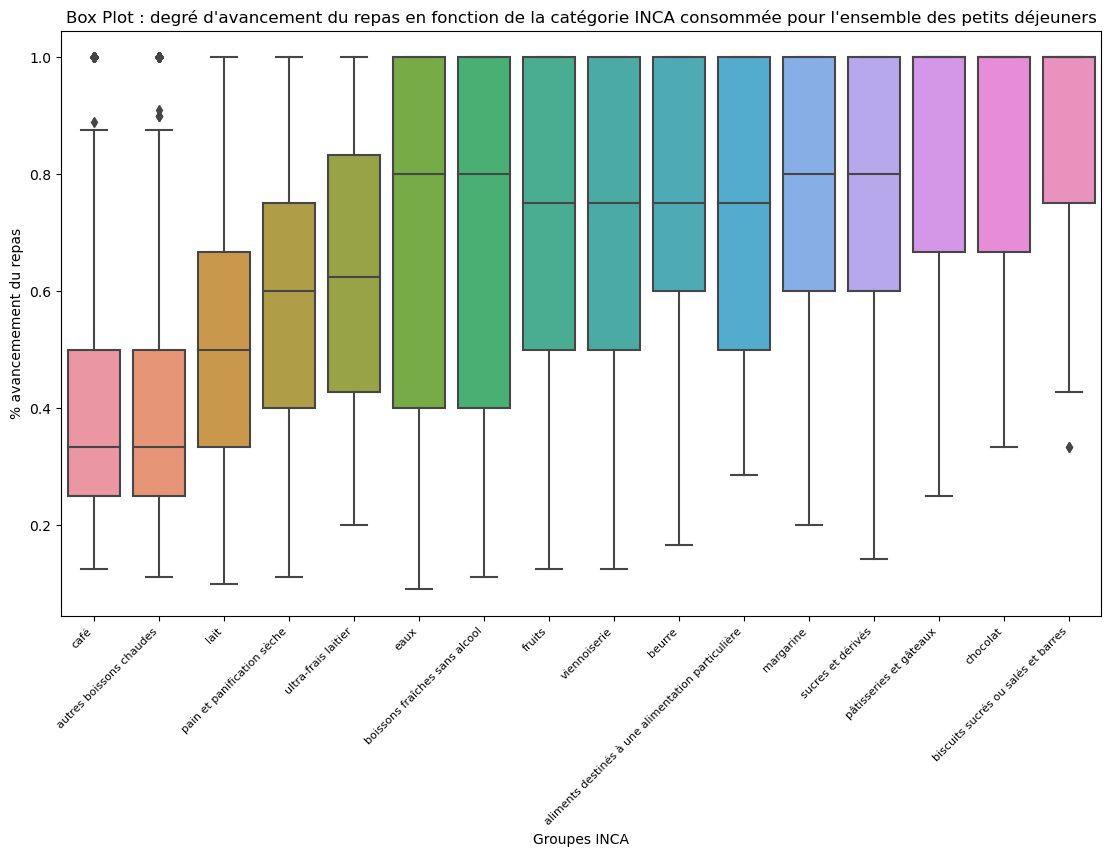

In [44]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de dictionnaire avec des données catégoriques
donnees = place_repas

# Aplatir les listes contenues dans le dictionnaire
donnees_aplaties = [(cle, valeur) for cle, valeurs in donnees.items() for valeur in valeurs]


# Créer un DataFrame Pandas à partir des données aplaties
df = pd.DataFrame(donnees_aplaties, columns=['Groupes INCA', '% avancemement du repas'])


# Créer un box plot avec Seaborn
plt.figure(figsize=(13, 9))
ax = sns.boxplot(data=df, x='Groupes INCA', y='% avancemement du repas', order=clés_triées)
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=8)

ax.set_position([0.1, 0.25, 0.8, 0.65])

# Ajouter un titre au graphique
plt.title("Box Plot : degré d'avancement du repas en fonction de la catégorie INCA consommée pour l'ensemble des petits déjeuners")

plt.savefig('box_plot_ensemble_repas_reels.pdf', format='pdf')

# Afficher le box plot
plt.show()


In [45]:
# REPAS PREDIT PAR RNN ET REPAS REEL pour l'ensmble test 

def pred_and_real_meal(preprocessor, model):
    model = model.to(device)
    loss = nn.CrossEntropyLoss(ignore_index=preprocessor.pad_index)  # classification avec une classe qui ne retourne pas d'erreur
    model.eval()
    rep_all_pred=[]
    rep_all_reel=[]
    with torch.no_grad():
        for batch in test_loader:
            rep_pred=[]
            rep_reel=[]
            sequences, user_index = batch
            x = preprocessor.process_batch(sequences).to(device)
            user_index = user_index.to(device)
            x_old, y_old = x[:-1], x[1:]
            yhat_old, hidden = model(x_old, user_index)
            x, y = x_old[:-1], y_old[:-1]
            yhat = yhat_old[:-1, :, :]
            # print(yhat.shape)
            predicted_classes = torch.argmax(yhat, dim=2)
            for i in range(len(predicted_classes)):
                predicted = predicted_classes[i]
                # print(predicted.item())
                y_val=y[i]
                # print(y_val.item())
                if predicted !=3:
                    decoded_class = preprocessor.decode([predicted.item()])# Appel de decode pour chaque élément individuellement
                    decoded_y= preprocessor.decode([y_val.item()])
                    rep_pred.append(decoded_class)
                    rep_reel.append(decoded_y)
            rep_all_pred.append(rep_pred)
            rep_all_reel.append(rep_reel)
    return rep_all_pred, rep_all_reel

rep_all_pred, rep_all_reel = pred_and_real_meal(preprocessor, rnn_model)
print(rep_all_pred)
print(rep_all_reel)

[['18004', '19041', '31016', '7300'], ['18004', '7601', '7601', '2012'], ['18004', '7001', '81052'], ['18020', '19041'], ['19050', '18150'], ['18004', '81052'], ['18004', '19041', '7620', '31006'], ['18151', '19041', '31016', '2012'], ['7730', '16400', '18004'], ['18020', '18066', '7001', '16400', '31006', '31006', '81052'], ['18020', '31016', '31016', '31016'], ['18005', '18066', '31016'], ['19041', '31016', '31016', '31016'], ['18073', '7200', '16412', '31110'], ['18004'], ['18004', '31016', '18066'], ['18004', '19041', '31016', '31016', '7001'], ['18004', '7001', '16400', '81052'], ['18004', '18004', '31016'], ['18004', '19041', '19041', '7001'], ['18151', '7001', '16400', '31017'], ['18151', '19041', '7001', '16400', '81052'], ['18151', '7100'], ['18005', '18066', '7001', '16400', '31008'], ['18020', '18020', '31008'], ['18004', '31016'], ['18004', '19041', '92030', '16400', '31006', '31017'], ['18020', '24630', '24630'], ['19041', '19041', '7740'], ['18066', '18020', '31008', '310

In [46]:
pred_rep_food_groups_testset=[]
for repas in rep_all_pred:
    r=[]
    for e in repas:
        r.append(dic_alim_group[int(e.replace("'",""))])
    pred_rep_food_groups_testset.append(r)
    
print(pred_rep_food_groups_testset)

[[34, 9, 30, 1], [34, 6, 6, 32], [34, 1, 30], [35, 9], [9, 35], [34, 30], [34, 9, 6, 30], [34, 9, 30, 32], [6, 13, 34], [35, 31, 1, 13, 30, 30, 30], [35, 30, 30, 30], [34, 31, 30], [9, 30, 30, 30], [34, 1, 13, 30], [34], [34, 30, 31], [34, 9, 30, 30, 1], [34, 1, 13, 30], [34, 34, 30], [34, 9, 9, 1], [34, 1, 13, 30], [34, 9, 1, 13, 30], [34, 1], [34, 31, 1, 13, 30], [35, 35, 30], [34, 30], [34, 9, 1, 13, 30, 30], [35, 8, 8], [9, 9, 6], [31, 35, 30, 30, 1], [34, 44, 1, 15], [35, 9], [1], [34, 44], [34, 9, 1, 30, 30], [34, 1, 13, 30], [34, 9, 9, 30], [34, 1], [31, 1, 30, 13, 31], [34, 9, 1, 15, 30], [9, 35, 1, 1], [35, 35], [35, 10, 1, 30], [32, 13], [9, 35, 32, 6, 13], [9, 30, 1], [34, 32, 1, 13, 30], [6, 30, 1], [1, 13, 9], [31, 9], [34], [34, 30, 13], [35, 31, 9, 1, 13], [9, 31, 1, 29, 35], [34, 30], [34, 34, 30, 30, 30], [32, 34, 1, 30], [34, 44], [34, 1, 15], [34, 9, 30, 30], [34, 30], [35, 1, 13, 30], [35, 9, 1, 13], [9, 35], [32, 34, 1, 13], [9, 35, 6, 13, 30], [34, 9, 30], [34, 34

In [47]:
reel_rep_food_groups_testset=[]
for repas in rep_all_reel:
    r=[]
    for e in repas:
        r.append(dic_alim_group[int(e.replace("'",""))])
    reel_rep_food_groups_testset.append(r)

print(reel_rep_food_groups_testset)

[[34, 9, 30, 6], [34, 30, 6, 32], [34, 31, 30], [35, 9], [9, 6], [34, 30], [34, 9, 1, 30], [34, 9, 30, 6], [1, 13, 34], [35, 31, 1, 13, 30, 30, 30], [34, 1, 32, 30], [34, 31, 30], [9, 34, 31, 1], [34, 1, 13, 30], [34], [34, 30, 31], [34, 9, 31, 30, 8], [34, 1, 13, 30], [1, 34, 30], [34, 30, 9, 1], [34, 1, 13, 30], [34, 9, 1, 30, 30], [32, 8], [34, 31, 1, 13, 30], [1, 13, 35], [34, 30], [34, 9, 1, 13, 30, 30], [35, 44, 8], [35, 9, 6], [31, 35, 30, 30, 1], [34, 44, 1, 15], [35, 9], [9], [34, 44], [34, 9, 1, 31, 30], [34, 1, 13, 30], [35, 1, 31, 30], [34, 30], [35, 1, 30, 13, 31], [34, 9, 1, 15, 30], [9, 35, 30, 6], [9, 35], [35, 10, 1, 30], [1, 13], [9, 35, 32, 1, 13], [9, 30, 1], [34, 32, 1, 13, 30], [34, 9, 30], [1, 13, 9], [34, 30], [34], [34, 30, 13], [35, 31, 9, 1, 13], [9, 31, 1, 26, 35], [34, 30], [1, 9, 34, 30, 30], [32, 34, 1, 30], [34, 44], [34, 1, 6], [34, 9, 1, 30], [34, 30], [35, 1, 13, 26], [35, 9, 1, 13], [9, 35], [32, 34, 1, 13], [9, 35, 1, 13, 30], [34, 9, 30], [6, 6], [

In [48]:
# import itertools
# from itertools import chain

# Aplatir la liste de listes en une seule liste
liste_pred_aplatie = list(chain(*pred_rep_food_groups_testset))

# Identifier les valeurs uniques
valeurs_uniques_pred = set(liste_pred_aplatie)
print(valeurs_uniques_pred)


place_repas_pred={}
for g in valeurs_uniques_pred:
    place_repas_pred[dic_group[g]]=[]

for repas in pred_rep_food_groups_testset:
    for g in repas:
        place_repas_pred[dic_group[g]].append((repas.index(g)+1)/len(repas))
print(place_repas_pred)

place_moy_repas_pred={}
for g in list(place_repas_pred.keys()):
    place_moy_repas_pred[g]=round(sum(place_repas_pred[g])/len(place_repas_pred[g]),3)
print(place_moy_repas_pred)


x=[]
y=[]
for cle,valeur in place_repas_pred.items():
    for e in valeur:
        x.append(cle)
        y.append(valeur)
print(x[:20])
print(y[:20])

clés_triées_pred = sorted(place_moy_repas_pred, key=lambda clé: place_moy_repas_pred[clé])
print(clés_triées_pred)

{32, 1, 34, 35, 6, 7, 8, 9, 10, 44, 13, 15, 26, 29, 30, 31}
{'boissons fraîches sans alcool': [1.0, 1.0, 0.5, 0.6, 0.4, 0.25, 0.25, 0.25, 1.0, 1.0, 0.16666666666666666, 0.5, 0.2, 1.0, 0.2, 1.0, 0.5, 0.5, 1.0, 0.75, 0.6, 0.8333333333333334, 0.75, 0.2857142857142857, 0.75, 0.75, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.2, 0.6, 0.8, 0.8, 1.0, 0.5, 0.75, 0.75, 0.2, 1.0, 0.5, 0.25, 0.14285714285714285, 0.6, 1.0, 0.16666666666666666, 0.16666666666666666, 0.25, 0.8571428571428571, 0.1, 0.1, 0.2, 1.0, 0.625, 0.2, 0.5, 0.125, 0.125, 0.25, 0.25, 0.3333333333333333, 0.6666666666666666, 0.75, 0.5, 1.0, 0.5, 0.5, 1.0, 0.42857142857142855, 0.16666666666666666, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333, 1.0, 0.2, 1.0, 1.0, 1.0, 0.6666666666666666, 0.8, 0.16666666666666666, 0.14285714285714285, 1.0, 0.3333333333333333, 1.0, 0.3333333333333333, 0.75, 0.75, 0.5, 0.5, 1.0, 0.8571428571428571, 1.0, 0.75, 1.0, 0.14285714285

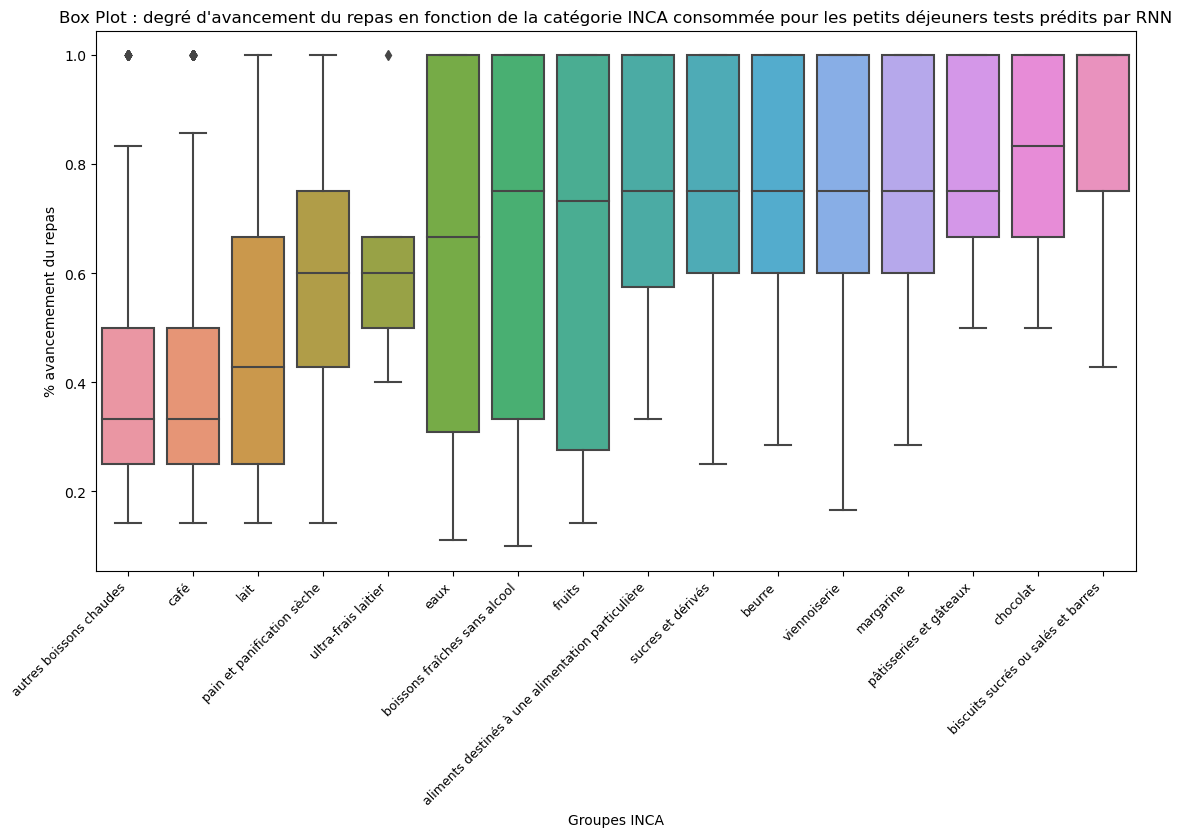

In [49]:
# Exemple de dictionnaire avec des données catégoriques
donnees = place_repas_pred

# Aplatir les listes contenues dans le dictionnaire
donnees_aplaties = [(cle, valeur) for cle, valeurs in donnees.items() for valeur in valeurs]


# Créer un DataFrame Pandas à partir des données aplaties
df = pd.DataFrame(donnees_aplaties, columns=['Groupes INCA', '% avancemement du repas'])


# Créer un box plot avec Seaborn
plt.figure(figsize=(13, 9))
ax = sns.boxplot(data=df, x='Groupes INCA', y='% avancemement du repas', order=clés_triées_pred)
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=9)

ax.set_position([0.1, 0.3, 0.8, 0.6])

# Ajouter un titre au graphique
plt.title("Box Plot : degré d'avancement du repas en fonction de la catégorie INCA consommée pour les petits déjeuners tests prédits par RNN")

plt.savefig('box_plot_repas_test_preditsRNN.pdf', format='pdf')

# Afficher le box plot
plt.show()

In [50]:

# Aplatir la liste de listes en une seule liste
liste_reel_aplatie = list(chain(*reel_rep_food_groups_testset))

# Identifier les valeurs uniques
valeurs_uniques_reel = set(liste_reel_aplatie)
print(valeurs_uniques_reel)


place_repas_reel={}
for g in valeurs_uniques_reel:
    place_repas_reel[dic_group[g]]=[]

for repas in reel_rep_food_groups_testset:
    for g in repas:
        place_repas_reel[dic_group[g]].append((repas.index(g)+1)/len(repas))
print(place_repas_reel)

place_moy_repas_reel={}
for g in list(place_repas_reel.keys()):
    place_moy_repas_reel[g]=round(sum(place_repas_reel[g])/len(place_repas_reel[g]),3)
print(place_moy_repas_reel)


x=[]
y=[]
for cle,valeur in place_repas_reel.items():
    for e in valeur:
        x.append(cle)
        y.append(valeur)
print(x[:20])
print(y[:20])

clés_triées_reel = sorted(place_moy_repas_reel, key=lambda clé: place_moy_repas_reel[clé])
print(clés_triées_reel)

{32, 1, 34, 35, 6, 7, 8, 9, 10, 44, 13, 15, 26, 29, 30, 31}
{'boissons fraîches sans alcool': [1.0, 0.75, 0.5, 0.6, 0.4, 0.25, 0.25, 1.0, 1.0, 0.6666666666666666, 1.0, 0.16666666666666666, 0.4, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.75, 0.6, 0.8571428571428571, 0.75, 0.8333333333333334, 0.75, 0.2857142857142857, 0.75, 0.4, 0.75, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.2, 0.6, 1.0, 0.3333333333333333, 1.0, 0.5, 0.6, 0.8, 1.0, 0.16666666666666666, 1.0, 1.0, 0.75, 1.0, 0.5, 0.14285714285714285, 0.6, 1.0, 0.16666666666666666, 0.25, 0.8571428571428571, 0.3, 0.2, 1.0, 0.8, 0.2, 0.75, 0.125, 0.3333333333333333, 0.6666666666666666, 1.0, 0.75, 0.5, 1.0, 0.75, 0.5, 0.5, 1.0, 0.42857142857142855, 0.16666666666666666, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.75, 0.75, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.2, 1.0, 1.0, 0.5714285714285714, 0.8571428571428571, 0.42857142857142855, 0.25, 1.0, 0.6666666666666666, 1.0, 0.8, 1.0, 0.16666666666666666, 0.14285714285714285, 0.5, 1.0, 0.3

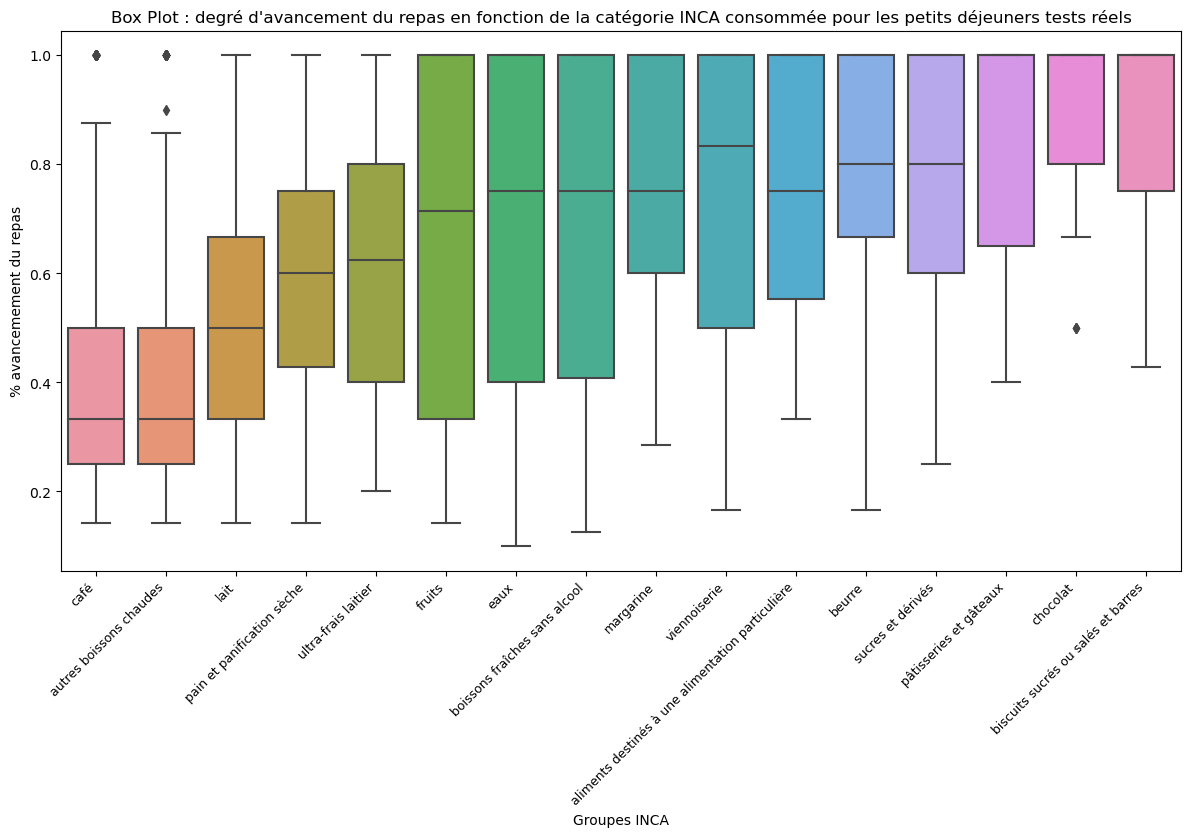

In [51]:
# Exemple de dictionnaire avec des données catégoriques
donnees = place_repas_reel

# Aplatir les listes contenues dans le dictionnaire
donnees_aplaties = [(cle, valeur) for cle, valeurs in donnees.items() for valeur in valeurs]


# Créer un DataFrame Pandas à partir des données aplaties
df = pd.DataFrame(donnees_aplaties, columns=['Groupes INCA', '% avancemement du repas'])


# Créer un box plot avec Seaborn
plt.figure(figsize=(14, 9))
ax = sns.boxplot(data=df, x='Groupes INCA', y='% avancemement du repas', order=clés_triées_reel)
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=9)

ax.set_position([0.1, 0.3, 0.8, 0.6])

# Ajouter un titre au graphique
plt.title("Box Plot : degré d'avancement du repas en fonction de la catégorie INCA consommée pour les petits déjeuners tests réels")

plt.savefig('box_plot_repas_test_reels.pdf', format='pdf')

# Afficher le box plot
plt.show()

['boissons fraîches sans alcool', 'pain et panification sèche', 'café', 'autres boissons chaudes', 'viennoiserie', 'biscuits sucrés ou salés et barres', 'pâtisseries et gâteaux', 'lait', 'ultra-frais laitier', 'aliments destinés à une alimentation particulière', 'beurre', 'margarine', 'fruits', 'chocolat', 'sucres et dérivés', 'eaux']
[1174, 4104, 5607, 1952, 1312, 161, 147, 2536, 109, 496, 2075, 775, 492, 199, 6315, 1306]


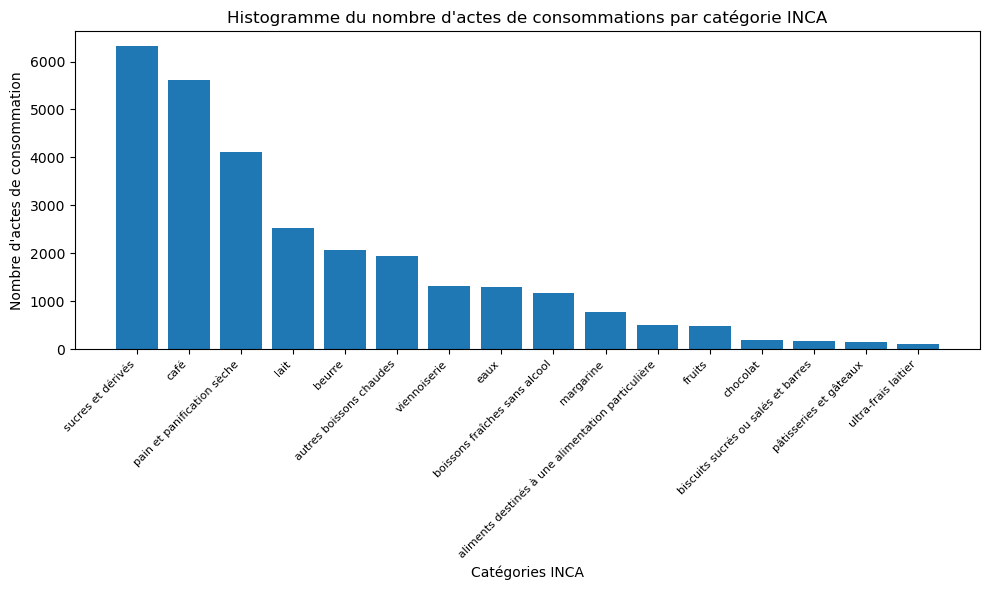

In [52]:
# Histogramme du nombre de consommation par catégorie INCA sur l'ensemble des repas réels 

# import itertools
# from itertools import chain

nombre_conso={}
for g in valeurs_uniques:
    nombre_conso[dic_group[g]]=[]

for repas in rep_food_groups:
    for g in repas:
        nombre_conso[dic_group[g]].append(1)
# print(nombre_conso)

nombre_conso_sum={}
for g in list(nombre_conso.keys()):
    nombre_conso_sum[g]=(sum(nombre_conso[g]))
# print(nombre_conso_sum)

x=[]
y=[]
for cle,valeur in nombre_conso_sum.items():
    x.append(cle)
    y.append(valeur)
print(x[:20])
print(y[:20])

# Trier les données par ordre décroissant en fonction de y
x_sorted, y_sorted = zip(*sorted(zip(x, y), key=lambda x: x[1], reverse=True))

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.bar(x_sorted, y_sorted)

# Ajouter des étiquettes et un titre
plt.xlabel("Catégories INCA")
plt.ylabel("Nombre d'actes de consommation")
plt.title("Histogramme du nombre d'actes de consommations par catégorie INCA")

# Ajuster l'espacement entre les étiquettes de l'axe des x pour éviter le chevauchement
plt.xticks(rotation=45, ha='right', fontsize=8)

plt.tight_layout() 

plt.savefig('box_plot_nombre_conso.pdf', format='pdf')

# Afficher l'histogramme
plt.show()